# thal2 get tables for xpp

1. Manually create XPP-compatible tables for the $\mathcal{H}$-functions.
2. Get Fourier coefficients for $\mathcal{H}$-functions (might not implement. we'll see)
3. Output LaTeX compatible plain text.

To create XPP-compatible tables, recall from [here](https://sites.pitt.edu/~phase/bard/bardware/xpp/help/xppodes.html): that we require the format:

```
npts
xlo
xhi
y(xlo)
...
y(xhi)
```

The domain of the function is `[xlo,xhi]`

In XPP, the format to load the file is given by,

`table name filename`



**Fourier notes**

Recall: Given the fourier coefficients $c_n$ for $n \in\mathbb{Z}$ and supposing that $c_n = a_n + i b_n$, the real Fourier series is given by,
$$\sum_{n =1}^\infty 2 a_n \cos(n \omega t) - 2 b_n \sin(n \omega t).$$
So I really only need to save the coefficients for positive frequencies and double them. 

Goal: given a function, display a list of coefficients (maybe implement text output to copy/past into XPP)

# Inits

In [1]:
import sys; sys.path.insert(0, '..') # add parent folder path where lib folder is
# user-defined
import nmCoupling as nm
# import nmCoupling_old as nm
import response as rp

import thal2 as t2

from lib.util import get_phase, bif1d, follow_phase_diffs

from lib.rhs import _redu_c2,_full, _redu_full

from lib.plot_util import (add_diagram_1d_scatter, quick_plot_combined, 
                            draw_quick_plot_f, add_diagram_1d_del_scatter)


import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
import sympy as sym

from scipy.signal import find_peaks
from scipy.optimize import root,bisect
from copy import deepcopy
import os

plt.rcParams.update({
    "text.usetex": True,
    "font.family": "Helvetica"
})

nmc = nm.nmCoupling
rsp = rp.Response

## Dicts

In [2]:
kw_sim = {'rtol':1e-9,'atol':1e-9,'method':'LSODA'}

In [3]:
pd1 = {'gL':0.05,'gna':3,'gk':5,
       'gt':5,'eL':-70,'ena':50,
       'ek':-90,'et':0,'esyn':-1,
       'c':1,'alpha':3,'beta':2,
       'sigmat':0.8,'vt':-20,
       'ib':8.5,'del':0,'om':1,'om_fix':1}

In [4]:
# default period must be 2*np.pi
kws1 = {'var_names':['v','h','r','w'],
        'pardict':pd1,
        'rhs':t2.rhs,
        'coupling':t2.coupling,
        'init':np.array([-.64,0.71,0.25,0,6]),
        'TN':20000,
        'trunc_order':1,
        'z_forward':False,
        'i_forward':[False,True,False,False,False,False],
        'i_bad_dx':[False,True,False,False,False,False],
        'max_iter':50,
        'rtol':1e-12,
        'atol':1e-12,
        'rel_tol':1e-9,
        'save_fig':False,
        'lc_prominence':.05,
        'factor':1}

## Defs

In [5]:
data_dir = 'xpp_tables/'
if not(os.path.isdir(data_dir)):
    os.mkdir(data_dir)

In [6]:
kw_bif = {'method':'LSODA','dense_output':True,'rtol':1e-9,'atol':1e-9}

In [7]:
x_temp = np.linspace(-np.pi,3*np.pi,500)

In [8]:
ss,dss=np.linspace(0,2,100,retstep=True)

In [9]:
def get_coeffs(data,threshold = 0.1):
    coeffs = np.fft.fft(data)
    
    # get coeffs above threshold
    NH = len(data)
    
    coeffs_re_all = np.real(coeffs)
    coeffs_im_all = np.imag(coeffs)
    nn = np.arange(len(coeffs),dtype='int')
    
    coeffs_re_bool = (np.abs(coeffs_re_all) > threshold)*(nn<NH/2)
    coeffs_im_bool = (np.abs(coeffs_im_all) > threshold)*(nn<NH/2)
    
    freqs = np.fft.fftfreq(len(coeffs),d=(1/a.NH))
    
    coeffs_re = coeffs_re_all[coeffs_re_bool]
    coeffs_im = coeffs_im_all[coeffs_im_bool]
    
    freqs[coeffs_re_bool]

    return coeffs_re, coeffs_im, freqs[coeffs_re_bool], freqs[coeffs_im_bool]

def call_fourier_series(a,coeffs_re,coeffs_im,fr,fi):
    tot = 0
    for i,c in enumerate(coeffs_re):
        if fr[i] == 0:
            tot += c/a11.NH
        else:
            tot += 2*c*np.cos(a.x*fr[i])/a.NH
    
    for i,c in enumerate(coeffs_im):
        tot += -2*c*np.sin(a.x*fi[i])/a.NH

    return tot

def print_fourier_series(a,coeffs_re,coeffs_im,fr,fi):
    # display copy/paste-able equation
    eq = ''
    for i,c in enumerate(coeffs_re):
        if fr[i] == 0:
            eq += '{:.4f}'.format(c/a11.NH)
        else:
            eq += '+2*cos(x*{})*({:.4f})'.format(fr[i],c/a.NH)
    
    for i,c in enumerate(coeffs_im):
        eq += '-2*sin(x*{})*({:.4f})'.format(fi[i],c/a.NH)
        #tot += -2*c*np.sin(x*freqs[coeffs_re_bool][i])/a11.NH
    return eq


In [10]:
def print_fourier_series_tex(a,coeffs_re,coeffs_im,fr,fi):
    # display copy/paste-able equation
    eq = ''
    for i,c in enumerate(coeffs_re):
        if fr[i] == 0:
            eq += '{:.4f}'.format(c/a11.NH)
        else:
            coeff = 2*c/a.NH
            if coeff < 0:
                sign = '-'
            else:
                sign = '+'
            eq += sign+'{:.4f}\\cos({}x) '.format(abs(coeff),int(fr[i]))
    
    for i,c in enumerate(coeffs_im):
        coeff = -2*c/a.NH
        if coeff < 0:
            sign = '-'
        else:
            sign = '+'
        eq += sign+'{:.4f}\\sin({}x) '.format(abs(coeff),int(fi[i]))
        #tot += -2*c*np.sin(x*freqs[coeffs_re_bool][i])/a11.NH
    return eq


## Initialize Response Functions

In [11]:
system1 = rsp(idx=0,model_name='thal0_85',**kws1)
system2 = rsp(idx=1,model_name='thal1_85',**kws1)

mkdir ./data/thal0_85/
* Loading LC data...
self.T 6.283185307179586 omfix 0.9901981522494304
* Loading monodromy...
* Floquet Exponent kappa =-0.02435447459817712
* Loading g symbolic...
* Computing g...
* Loading heterogeneous terms...
* Computing z...
* Computing i...
mkdir ./data/thal1_85/
* Loading LC data...
self.T 6.283185307179586 omfix 0.9901981522494304
* Loading monodromy...
* Floquet Exponent kappa =-0.02435447459817712
* Loading g symbolic...
* Computing g...
* Loading heterogeneous terms...
* Computing z...
* Computing i...


# Initialize Coupling 1:1

In [12]:
#recompute_list = ['k_thal0_85','k_thal1_85','h_thal0_85','h_thal1_85', 'h_data_thal0_85','h_data_thal1_85', 'p_data_thal0_85','p_data_thal1_85','p_thal0_85','p_thal1_85']
# recompute_list = ['k_thal0_85','k_thal1_85']
recompute_list = []
kw_nm = {'system1':system1,'system2':system2,'_n':('om0',1),'_m':('om1',1),
         'NH':1024,'save_fig':False, 'recompute_list':recompute_list,
         'het_coeffs':[1,100], # [eps, eps^2, etc]
        }
a11 = nm.nmCoupling(**kw_nm)

Initializing 11 Coupling...
pfactor 30
* Loading p symbolic...
* Loading p symbolic...
p order=0
p order=0
* Loading H symbolic...
* Loading H symbolic...
* Loading H thal0_85, order=0...
* Loading H thal1_85, order=0...
* Loading H thal0_85, order=1...
* Loading H thal1_85, order=1...


## osc 1

### eps

In [13]:
a = a11
system = a.system1
data_hom = system.h['dat_hom'][0]
coeffs_re, coeffs_im, fr, fi = get_coeffs(data_hom,threshold=1)
tot1o1 = call_fourier_series(a,coeffs_re,coeffs_im,fr,fi)
print('')
# print('hom osc 1 order 1',print_fourier_series(a,coeffs_re,coeffs_im,fr,fi))
print('hom osc 1 order 1',print_fourier_series_tex(a,coeffs_re,coeffs_im,fr,fi))

data_het = system.h['dat_het'][0][0]
coeffs_re, coeffs_im, fr, fi = get_coeffs(data_het,threshold=0)
tot1o1c1 = call_fourier_series(a,coeffs_re,coeffs_im,fr,fi)
print('')
print('het osc 1 order 1, c1',print_fourier_series(a,coeffs_re,coeffs_im,fr,fi))


hom osc 1 order 1 0.2342-0.2549\cos(1x) -0.0167\cos(2x) +0.0092\cos(3x) +0.0050\cos(4x) +0.0020\cos(5x) -0.0646\sin(1x) +0.0095\sin(3x) +0.0038\sin(4x) 

het osc 1 order 1, c1 -5.9757


### eps^2

In [14]:
system = a.system1
data_hom = system.h['dat_hom'][1]
coeffs_re, coeffs_im, fr, fi = get_coeffs(data_hom,threshold=1)
tot1o2 = call_fourier_series(a,coeffs_re,coeffs_im,fr,fi)
print('')
print('hom osc 1 order 2',print_fourier_series_tex(a,coeffs_re,coeffs_im,fr,fi))

data_hets = system.h['dat_het'][1]

coeffs_re, coeffs_im, fr, fi = get_coeffs(data_hets[0],threshold=10)
tot1o2c1 = call_fourier_series(a,coeffs_re,coeffs_im,fr,fi)
print('')
print('het osc 1 order 2, c1',print_fourier_series_tex(a,coeffs_re,coeffs_im,fr,fi))

coeffs_re, coeffs_im, fr, fi = get_coeffs(data_hets[1],threshold=10)
tot1o2c2 = call_fourier_series(a,coeffs_re,coeffs_im,fr,fi)
print('')
print('het osc 1 order 2, c2',print_fourier_series_tex(a,coeffs_re,coeffs_im,fr,fi))


hom osc 1 order 2 0.1225+0.0198\cos(1x) -0.1412\cos(2x) -0.0335\cos(3x) +0.0161\cos(4x) +0.0114\cos(5x) +0.0035\cos(6x) +0.0044\sin(1x) -0.0393\sin(2x) -0.0098\sin(3x) +0.0130\sin(4x) +0.0089\sin(5x) 

het osc 1 order 2, c1 -0.1329+0.3773\cos(1x) +0.0519\cos(2x) -0.1553\cos(3x) -0.0872\cos(4x) -1.5871\sin(1x) -0.2154\sin(2x) +0.1683\sin(3x) +0.1167\sin(4x) +0.0569\sin(5x) +0.0276\sin(6x) 

het osc 1 order 2, c2 -595.9792


## osc 2

### eps

In [15]:
system = a.system2
data_hom = system.h['dat_hom'][0]
coeffs_re, coeffs_im, fr, fi = get_coeffs(data_hom,threshold=1)
tot2o1 = call_fourier_series(a,coeffs_re,coeffs_im,fr,fi)
print('')
print('hom osc 2 order 1',print_fourier_series_tex(a,coeffs_re,coeffs_im,fr,fi))

data_het = system.h['dat_het'][0][0]
coeffs_re, coeffs_im, fr, fi = get_coeffs(data_het,threshold=0)
tot2o1c1 = call_fourier_series(a,coeffs_re,coeffs_im,fr,fi)
print('')
print('het osc 2 order 1, c1',print_fourier_series_tex(a,coeffs_re,coeffs_im,fr,fi))


hom osc 2 order 1 0.2342-0.2549\cos(1x) -0.0167\cos(2x) +0.0092\cos(3x) +0.0050\cos(4x) +0.0020\cos(5x) +0.0646\sin(1x) -0.0095\sin(3x) -0.0038\sin(4x) 

het osc 2 order 1, c1 


### eps^2

In [16]:
system = a.system2
data_hom = system.h['dat_hom'][1]
coeffs_re, coeffs_im, fr, fi = get_coeffs(data_hom,threshold=1)
tot2o2 = call_fourier_series(a,coeffs_re,coeffs_im,fr,fi)
print('')
print('hom osc 2 order 2',print_fourier_series_tex(a,coeffs_re,coeffs_im,fr,fi))

data_hets = system.h['dat_het'][1]

coeffs_re, coeffs_im, fr, fi = get_coeffs(data_hets[0],threshold=10)
tot2o2c1 = call_fourier_series(a,coeffs_re,coeffs_im,fr,fi)
print('')
print('het osc 2 order 2, c1',print_fourier_series_tex(a,coeffs_re,coeffs_im,fr,fi))

coeffs_re, coeffs_im, fr, fi = get_coeffs(data_hets[1],threshold=10)
tot2o2c2 = call_fourier_series(a,coeffs_re,coeffs_im,fr,fi)
print('')
print('het osc 2 order 2, c2',print_fourier_series_tex(a,coeffs_re,coeffs_im,fr,fi))


hom osc 2 order 2 0.1225+0.0198\cos(1x) -0.1412\cos(2x) -0.0335\cos(3x) +0.0161\cos(4x) +0.0114\cos(5x) +0.0035\cos(6x) -0.0044\sin(1x) +0.0393\sin(2x) +0.0098\sin(3x) -0.0130\sin(4x) -0.0089\sin(5x) 

het osc 2 order 2, c1 -0.3363\cos(1x) +0.1566\cos(3x) +0.0843\cos(4x) -1.4361\sin(1x) -0.1853\sin(2x) +0.1536\sin(3x) +0.1112\sin(4x) +0.0559\sin(5x) +0.0274\sin(6x) 

het osc 2 order 2, c2 


## Plot

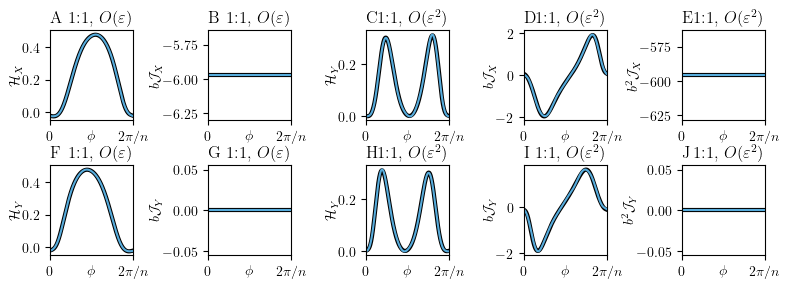

In [17]:
labels = ['A ','B ','C ','D ','E ','F ','G ','H' ,'I ','J ']
titles = [r'$O(\varepsilon)$',r'$O(\varepsilon)$',
          r'$O(\varepsilon^2)$',r'$O(\varepsilon^2)$',r'$O(\varepsilon^2)$',
         r'$O(\varepsilon)$',r'$O(\varepsilon)$',
          r'$O(\varepsilon^2)$',r'$O(\varepsilon^2)$',r'$O(\varepsilon^2)$']

pi_label_short = [r"$0$", r"$2\pi/n$"]
import matplotlib
matplotlib.rcParams['font.family'] = 'serif'
matplotlib.rcParams['text.usetex'] = True
matplotlib.rcParams['pgf.texsystem'] = 'pdflatex'
#matplotlib.rcParams['font.size'] = 12


preamble = (r'\usepackage{amsmath}'
            r'\usepackage{siunitx}'
            r'\usepackage{bm}'
            r'\newcommand{\ve}{\varepsilon}')

matplotlib.rcParams['text.latex.preamble'] = preamble
fontsize = 12

fig,axs = plt.subplots(2,5,figsize=(8,3))

axs[0,0].plot(a.x,a.system1.h['dat_hom'][0],color='k',lw=3)
axs[0,0].plot(a.x,tot1o1,label = 'Approx.',color='#57acdc')


axs[0,1].plot(a.x,a.system1.h['dat_het'][0][0],color='k',lw=3)
axs[0,1].plot(a.x,tot1o1c1+0*a.x,label = 'Approx.',color='#57acdc')

axs[0,2].plot(a.x,a.system1.h['dat_hom'][1],color='k',lw=3)
axs[0,2].plot(a.x,tot1o2,color='#57acdc')


axs[0,3].plot(a.x,a.system1.h['dat_het'][1][0],color='k',lw=3)
axs[0,3].plot(a.x,tot1o2c1+0*a.x,color='#57acdc')

axs[0,4].plot(a.x,a.system1.h['dat_het'][1][1],color='k',lw=3)
axs[0,4].plot(a.x,tot1o2c2+0*a.x,color='#57acdc')

axs[1,0].plot(a.x,a.system2.h['dat_hom'][0],color='k',lw=3)
axs[1,0].plot(a.x,tot2o1,color='#57acdc')

axs[1,1].plot(a.x,a.system2.h['dat_het'][0][0],color='k',lw=3)
axs[1,1].plot(a.x,tot2o1c1+0*a.x,color='#57acdc')

axs[1,2].plot(a.x,a.system2.h['dat_hom'][1],color='k',lw=3)
axs[1,2].plot(a.x,tot2o2,color='#57acdc')

axs[1,3].plot(a.x,a.system2.h['dat_het'][1][0],color='k',lw=3)
axs[1,3].plot(a.x,tot2o2c1+0*a.x,color='#57acdc')

axs[1,4].plot(a.x,a.system2.h['dat_het'][1][1],color='k',lw=3)
axs[1,4].plot(a.x,tot2o2c2+0*a.x,color='#57acdc')


axs = axs.flatten()
for k,label in enumerate(labels):
    axs[k].set_title(label,loc='left')
    axs[k].set_xticks([0,2*np.pi/a._n[1]])
    axs[k].set_xticklabels(pi_label_short)

    axs[k].set_xlabel(r'$\phi$',labelpad=-10);axs[k].set_xlim(0,2*np.pi/a._n[1])

    
    if k in [1,3]:
        axs[k].set_ylabel(r'$b\mathcal{J}_X$',labelpad=0)
    elif k in [6,8]:
        axs[k].set_ylabel(r'$b\mathcal{J}_Y$',labelpad=0)
    elif k in [4]:
        axs[k].set_ylabel(r'$b^2\mathcal{J}_X$',labelpad=0)
    elif k in [9]:
        axs[k].set_ylabel(r'$b^2\mathcal{J}_Y$',labelpad=0)
    elif k in [0,1]:
        axs[k].set_ylabel(r'$\mathcal{H}_X$',labelpad=0)
    else:
        axs[k].set_ylabel(r'$\mathcal{H}_Y$',labelpad=0)

    ti1 = axs[k].get_title()
    ti1 += r'$\quad$'+str(a._n[1])+':'+str(a._m[1])
    ti1 += ', '+titles[k]
        
    axs[k].set_title(ti1,loc='right')

# axs[0].legend()

plt.tight_layout()
plt.subplots_adjust(wspace=.9,hspace=.5)
plt.savefig('fourier{}{}.pdf'.format(a._n[1],a._m[1]))

#axs

# Initialize Coupling 1:2

In [18]:
#recompute_list = ['k_thal0_85','k_thal1_85','h_thal0_85','h_thal1_85', 'h_data_thal0_85','h_data_thal1_85', 'p_data_thal0_85','p_data_thal1_85','p_thal0_85','p_thal1_85']
# recompute_list = ['k_thal0_85','k_thal1_85']
recompute_list = []
kw_nm = {'system1':system1,'system2':system2,'_n':('om0',1),'_m':('om1',2),
         'NH':1024,'save_fig':False, 'recompute_list':recompute_list,
         'het_coeffs':[1,100], # [eps, eps^2, etc]
        }
a12 = nm.nmCoupling(**kw_nm)

Initializing 12 Coupling...
pfactor 30
* Loading p symbolic...
* Loading p symbolic...
p order=0
p order=0
* Loading H symbolic...
* Loading H symbolic...
* Loading H thal0_85, order=0...
* Loading H thal1_85, order=0...
* Loading H thal0_85, order=1...
* Loading H thal1_85, order=1...


## osc 1

### eps

In [19]:
a = a12
system = a.system1
data_hom = system.h['dat_hom'][0]
coeffs_re, coeffs_im, fr, fi = get_coeffs(data_hom,threshold=1)
tot1o1 = call_fourier_series(a,coeffs_re,coeffs_im,fr,fi)
print('')
print('hom osc 1 order 1',print_fourier_series_tex(a,coeffs_re,coeffs_im,fr,fi))

data_het = system.h['dat_het'][0][0]
coeffs_re, coeffs_im, fr, fi = get_coeffs(data_het,threshold=0)
tot1o1c1 = call_fourier_series(a,coeffs_re,coeffs_im,fr,fi)
print('')
print('het osc 1 order 1, c1',print_fourier_series_tex(a,coeffs_re,coeffs_im,fr,fi))


hom osc 1 order 1 0.2342-0.0208\cos(2x) +0.0067\cos(4x) +0.0021\cos(6x) -0.0070\sin(2x) +0.0093\sin(4x) 

het osc 1 order 1, c1 -5.9757


### eps^2

In [20]:
system = a.system1
data_hom = system.h['dat_hom'][1]
coeffs_re, coeffs_im, fr, fi = get_coeffs(data_hom,threshold=1)
tot1o2 = call_fourier_series(a,coeffs_re,coeffs_im,fr,fi)
print('')
print('hom osc 1 order 2',print_fourier_series_tex(a,coeffs_re,coeffs_im,fr,fi))

data_hets = system.h['dat_het'][1]

coeffs_re, coeffs_im, fr, fi = get_coeffs(data_hets[0],threshold=10)
tot1o2c1 = call_fourier_series(a,coeffs_re,coeffs_im,fr,fi)
print('')
print('het osc 1 order 2, c1',print_fourier_series_tex(a,coeffs_re,coeffs_im,fr,fi))

coeffs_re, coeffs_im, fr, fi = get_coeffs(data_hets[1],threshold=10)
tot1o2c2 = call_fourier_series(a,coeffs_re,coeffs_im,fr,fi)
print('')
print('het osc 1 order 2, c2',print_fourier_series_tex(a,coeffs_re,coeffs_im,fr,fi))


hom osc 1 order 2 0.0068-0.0105\cos(2x) +0.0049\cos(4x) -0.0026\cos(6x) +0.0081\sin(2x) -0.0091\sin(4x) +0.0051\sin(6x) 

het osc 1 order 2, c1 -0.1329+0.1519\cos(2x) -0.2134\cos(4x) +0.0251\cos(8x) -0.2476\sin(2x) +0.1569\sin(4x) +0.0697\sin(6x) +0.0246\sin(8x) 

het osc 1 order 2, c2 -595.9792


## osc 2

### eps

In [21]:
system = a.system2
data_hom = system.h['dat_hom'][0]
coeffs_re, coeffs_im, fr, fi = get_coeffs(data_hom,threshold=1)
tot2o1 = call_fourier_series(a,coeffs_re,coeffs_im,fr,fi)
print('')
print('hom osc 2 order 1',print_fourier_series_tex(a,coeffs_re,coeffs_im,fr,fi))

data_het = system.h['dat_het'][0][0]
coeffs_re, coeffs_im, fr, fi = get_coeffs(data_het,threshold=0)
tot2o1c1 = call_fourier_series(a,coeffs_re,coeffs_im,fr,fi)
print('')
print('het osc 2 order 1, c1',print_fourier_series_tex(a,coeffs_re,coeffs_im,fr,fi))


hom osc 2 order 1 0.2342-0.2001\cos(2x) -0.0088\cos(4x) +0.0045\cos(6x) -0.0132\sin(2x) -0.0026\sin(4x) -0.0031\sin(6x) 

het osc 2 order 1, c1 


### eps^2

In [22]:
system = a.system2
data_hom = system.h['dat_hom'][1]
coeffs_re, coeffs_im, fr, fi = get_coeffs(data_hom,threshold=1)
tot2o2 = call_fourier_series(a,coeffs_re,coeffs_im,fr,fi)
print('')
print('hom osc 2 order 2',print_fourier_series_tex(a,coeffs_re,coeffs_im,fr,fi))

data_hets = system.h['dat_het'][1]

coeffs_re, coeffs_im, fr, fi = get_coeffs(data_hets[0],threshold=10)
tot2o2c1 = call_fourier_series(a,coeffs_re,coeffs_im,fr,fi)
print('')
print('het osc 2 order 2, c1',print_fourier_series_tex(a,coeffs_re,coeffs_im,fr,fi))

coeffs_re, coeffs_im, fr, fi = get_coeffs(data_hets[1],threshold=10)
tot2o2c2 = call_fourier_series(a,coeffs_re,coeffs_im,fr,fi)
print('')
print('het osc 2 order 2, c2',print_fourier_series_tex(a,coeffs_re,coeffs_im,fr,fi))


hom osc 2 order 2 0.0368-0.0303\cos(4x) -0.0059\cos(6x) +0.0035\cos(8x) +0.0358\sin(2x) -0.0400\sin(4x) +0.0022\sin(6x) +0.0024\sin(8x) 

het osc 2 order 2, c1 +0.1786\cos(2x) +0.0576\cos(4x) +0.1024\cos(6x) +0.0450\cos(8x) -2.2168\sin(2x) -0.1944\sin(4x) +0.1486\sin(6x) +0.0670\sin(8x) 

het osc 2 order 2, c2 


## Plot

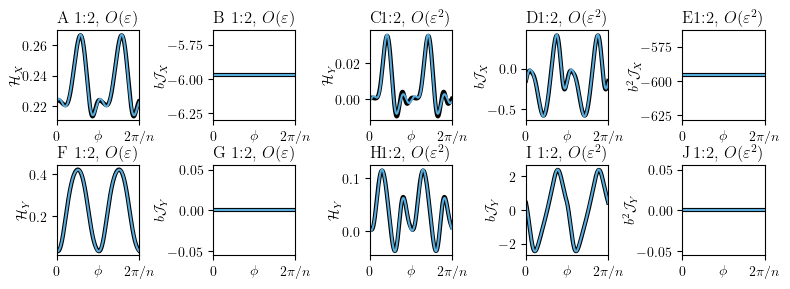

In [23]:
labels = ['A ','B ','C ','D ','E ','F ','G ','H' ,'I ','J ']
titles = [r'$O(\varepsilon)$',r'$O(\varepsilon)$',
          r'$O(\varepsilon^2)$',r'$O(\varepsilon^2)$',r'$O(\varepsilon^2)$',
         r'$O(\varepsilon)$',r'$O(\varepsilon)$',
          r'$O(\varepsilon^2)$',r'$O(\varepsilon^2)$',r'$O(\varepsilon^2)$']

pi_label_short = [r"$0$", r"$2\pi/n$"]
import matplotlib
matplotlib.rcParams['font.family'] = 'serif'
matplotlib.rcParams['text.usetex'] = True
matplotlib.rcParams['pgf.texsystem'] = 'pdflatex'
#matplotlib.rcParams['font.size'] = 12


preamble = (r'\usepackage{amsmath}'
            r'\usepackage{siunitx}'
            r'\usepackage{bm}'
            r'\newcommand{\ve}{\varepsilon}')

matplotlib.rcParams['text.latex.preamble'] = preamble
fontsize = 12

fig,axs = plt.subplots(2,5,figsize=(8,3))

axs[0,0].plot(a.x,a.system1.h['dat_hom'][0],color='k',lw=3)
axs[0,0].plot(a.x,tot1o1,label = 'Approx.',color='#57acdc')


axs[0,1].plot(a.x,a.system1.h['dat_het'][0][0],color='k',lw=3)
axs[0,1].plot(a.x,tot1o1c1+0*a.x,label = 'Approx.',color='#57acdc')

axs[0,2].plot(a.x,a.system1.h['dat_hom'][1],color='k',lw=3)
axs[0,2].plot(a.x,tot1o2,color='#57acdc')


axs[0,3].plot(a.x,a.system1.h['dat_het'][1][0],color='k',lw=3)
axs[0,3].plot(a.x,tot1o2c1+0*a.x,color='#57acdc')

axs[0,4].plot(a.x,a.system1.h['dat_het'][1][1],color='k',lw=3)
axs[0,4].plot(a.x,tot1o2c2+0*a.x,color='#57acdc')

axs[1,0].plot(a.x,a.system2.h['dat_hom'][0],color='k',lw=3)
axs[1,0].plot(a.x,tot2o1,color='#57acdc')

axs[1,1].plot(a.x,a.system2.h['dat_het'][0][0],color='k',lw=3)
axs[1,1].plot(a.x,tot2o1c1+0*a.x,color='#57acdc')

axs[1,2].plot(a.x,a.system2.h['dat_hom'][1],color='k',lw=3)
axs[1,2].plot(a.x,tot2o2,color='#57acdc')

axs[1,3].plot(a.x,a.system2.h['dat_het'][1][0],color='k',lw=3)
axs[1,3].plot(a.x,tot2o2c1+0*a.x,color='#57acdc')

axs[1,4].plot(a.x,a.system2.h['dat_het'][1][1],color='k',lw=3)
axs[1,4].plot(a.x,tot2o2c2+0*a.x,color='#57acdc')


axs = axs.flatten()
for k,label in enumerate(labels):
    axs[k].set_title(label,loc='left')
    axs[k].set_xticks([0,2*np.pi/a._n[1]])
    axs[k].set_xticklabels(pi_label_short)

    axs[k].set_xlabel(r'$\phi$',labelpad=-10);axs[k].set_xlim(0,2*np.pi/a._n[1])

    
    if k in [1,3]:
        axs[k].set_ylabel(r'$b\mathcal{J}_X$',labelpad=0)
    elif k in [6,8]:
        axs[k].set_ylabel(r'$b\mathcal{J}_Y$',labelpad=0)
    elif k in [4]:
        axs[k].set_ylabel(r'$b^2\mathcal{J}_X$',labelpad=0)
    elif k in [9]:
        axs[k].set_ylabel(r'$b^2\mathcal{J}_Y$',labelpad=0)
    elif k in [0,1]:
        axs[k].set_ylabel(r'$\mathcal{H}_X$',labelpad=0)
    else:
        axs[k].set_ylabel(r'$\mathcal{H}_Y$',labelpad=0)

    ti1 = axs[k].get_title()
    ti1 += r'$\quad$'+str(a._n[1])+':'+str(a._m[1])
    ti1 += ', '+titles[k]
        
    axs[k].set_title(ti1,loc='right')

# axs[0].legend()

plt.tight_layout()
plt.subplots_adjust(wspace=.9,hspace=.5)
plt.savefig('fourier{}{}.pdf'.format(a._n[1],a._m[1]))

#axs

# Initialize Coupling 2:1

In [24]:
#recompute_list = ['k_thal0_85','k_thal1_85','h_thal0_85','h_thal1_85', 'h_data_thal0_85','h_data_thal1_85', 'p_data_thal0_85','p_data_thal1_85','p_thal0_85','p_thal1_85']
# recompute_list = ['k_thal0_85','k_thal1_85']
recompute_list = []
kw_nm = {'system1':system1,'system2':system2,'_n':('om0',2),'_m':('om1',1),
         'NH':1024,'save_fig':False, 'recompute_list':recompute_list,
         'het_coeffs':[1,100], # [eps, eps^2, etc]
        }
a21 = nm.nmCoupling(**kw_nm)

Initializing 21 Coupling...
pfactor 30
* Loading p symbolic...
* Loading p symbolic...
p order=0
p order=0
* Loading H symbolic...
* Loading H symbolic...
* Loading H thal0_85, order=0...
* Loading H thal1_85, order=0...
* Loading H thal0_85, order=1...
* Loading H thal1_85, order=1...


## osc 1

### eps

In [25]:
a = a21
system = a.system1
data_hom = system.h['dat_hom'][0]
coeffs_re, coeffs_im, fr, fi = get_coeffs(data_hom,threshold=1)
tot1o1 = call_fourier_series(a,coeffs_re,coeffs_im,fr,fi)
print('')
print('hom osc 1 order 1',print_fourier_series_tex(a,coeffs_re,coeffs_im,fr,fi))

data_het = system.h['dat_het'][0][0]
coeffs_re, coeffs_im, fr, fi = get_coeffs(data_het,threshold=0)
tot1o1c1 = call_fourier_series(a,coeffs_re,coeffs_im,fr,fi)
print('')
print('het osc 1 order 1, c1',print_fourier_series_tex(a,coeffs_re,coeffs_im,fr,fi))


hom osc 1 order 1 0.2342-0.2001\cos(2x) -0.0088\cos(4x) +0.0045\cos(6x) +0.0132\sin(2x) +0.0026\sin(4x) +0.0031\sin(6x) 

het osc 1 order 1, c1 -5.9757


### eps^2

In [26]:
system = a.system1
data_hom = system.h['dat_hom'][1]
coeffs_re, coeffs_im, fr, fi = get_coeffs(data_hom,threshold=1)
tot1o2 = call_fourier_series(a,coeffs_re,coeffs_im,fr,fi)
print('')
print('hom osc 1 order 2',print_fourier_series_tex(a,coeffs_re,coeffs_im,fr,fi))

data_hets = system.h['dat_het'][1]

coeffs_re, coeffs_im, fr, fi = get_coeffs(data_hets[0],threshold=10)
tot1o2c1 = call_fourier_series(a,coeffs_re,coeffs_im,fr,fi)
print('')
print('het osc 1 order 2, c1',print_fourier_series_tex(a,coeffs_re,coeffs_im,fr,fi))

coeffs_re, coeffs_im, fr, fi = get_coeffs(data_hets[1],threshold=10)
tot1o2c2 = call_fourier_series(a,coeffs_re,coeffs_im,fr,fi)
print('')
print('het osc 1 order 2, c2',print_fourier_series_tex(a,coeffs_re,coeffs_im,fr,fi))


hom osc 1 order 2 0.0368-0.0303\cos(4x) -0.0059\cos(6x) +0.0035\cos(8x) -0.0358\sin(2x) +0.0400\sin(4x) -0.0022\sin(6x) -0.0024\sin(8x) 

het osc 1 order 2, c1 -0.1346-0.1011\cos(2x) -0.0490\cos(6x) -0.0230\cos(8x) -1.2527\sin(2x) -0.1229\sin(4x) +0.0814\sin(6x) +0.0356\sin(8x) 

het osc 1 order 2, c2 -595.9595


## osc 2

### eps

In [27]:
system = a.system2
data_hom = system.h['dat_hom'][0]
coeffs_re, coeffs_im, fr, fi = get_coeffs(data_hom,threshold=1)
tot2o1 = call_fourier_series(a,coeffs_re,coeffs_im,fr,fi)
print('')
print('hom osc 2 order 1',print_fourier_series_tex(a,coeffs_re,coeffs_im,fr,fi))

data_het = system.h['dat_het'][0][0]
coeffs_re, coeffs_im, fr, fi = get_coeffs(data_het,threshold=0)
tot2o1c1 = call_fourier_series(a,coeffs_re,coeffs_im,fr,fi)
print('')
print('het osc 2 order 1, c1',print_fourier_series_tex(a,coeffs_re,coeffs_im,fr,fi))


hom osc 2 order 1 0.2342-0.0208\cos(2x) +0.0067\cos(4x) +0.0021\cos(6x) +0.0070\sin(2x) -0.0093\sin(4x) 

het osc 2 order 1, c1 


### eps^2

In [28]:
system = a.system2
data_hom = system.h['dat_hom'][1]
coeffs_re, coeffs_im, fr, fi = get_coeffs(data_hom,threshold=1)
tot2o2 = call_fourier_series(a,coeffs_re,coeffs_im,fr,fi)
print('')
print('hom osc 2 order 2',print_fourier_series_tex(a,coeffs_re,coeffs_im,fr,fi))

data_hets = system.h['dat_het'][1]

coeffs_re, coeffs_im, fr, fi = get_coeffs(data_hets[0],threshold=10)
tot2o2c1 = call_fourier_series(a,coeffs_re,coeffs_im,fr,fi)
print('')
print('het osc 2 order 2, c1',print_fourier_series_tex(a,coeffs_re,coeffs_im,fr,fi))

coeffs_re, coeffs_im, fr, fi = get_coeffs(data_hets[1],threshold=10)
tot2o2c2 = call_fourier_series(a,coeffs_re,coeffs_im,fr,fi)
print('')
print('het osc 2 order 2, c2',print_fourier_series_tex(a,coeffs_re,coeffs_im,fr,fi))


hom osc 2 order 2 0.0068-0.0105\cos(2x) +0.0049\cos(4x) -0.0026\cos(6x) -0.0081\sin(2x) +0.0091\sin(4x) -0.0051\sin(6x) 

het osc 2 order 2, c1 -0.0373\cos(2x) +0.1034\cos(4x) -0.1184\sin(2x) +0.0769\sin(4x) +0.0346\sin(6x) 

het osc 2 order 2, c2 


## Plot

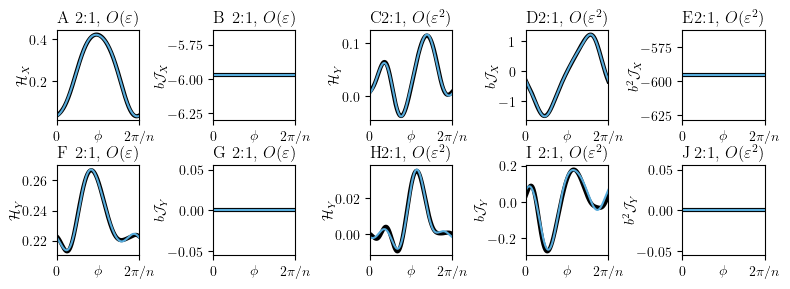

In [29]:
labels = ['A ','B ','C ','D ','E ','F ','G ','H' ,'I ','J ']
titles = [r'$O(\varepsilon)$',r'$O(\varepsilon)$',
          r'$O(\varepsilon^2)$',r'$O(\varepsilon^2)$',r'$O(\varepsilon^2)$',
         r'$O(\varepsilon)$',r'$O(\varepsilon)$',
          r'$O(\varepsilon^2)$',r'$O(\varepsilon^2)$',r'$O(\varepsilon^2)$']

pi_label_short = [r"$0$", r"$2\pi/n$"]
import matplotlib
matplotlib.rcParams['font.family'] = 'serif'
matplotlib.rcParams['text.usetex'] = True
matplotlib.rcParams['pgf.texsystem'] = 'pdflatex'
#matplotlib.rcParams['font.size'] = 12


preamble = (r'\usepackage{amsmath}'
            r'\usepackage{siunitx}'
            r'\usepackage{bm}'
            r'\newcommand{\ve}{\varepsilon}')

matplotlib.rcParams['text.latex.preamble'] = preamble
fontsize = 12

fig,axs = plt.subplots(2,5,figsize=(8,3))

axs[0,0].plot(a.x,a.system1.h['dat_hom'][0],color='k',lw=3)
axs[0,0].plot(a.x,tot1o1,label = 'Approx.',color='#57acdc')


axs[0,1].plot(a.x,a.system1.h['dat_het'][0][0],color='k',lw=3)
axs[0,1].plot(a.x,tot1o1c1+0*a.x,label = 'Approx.',color='#57acdc')

axs[0,2].plot(a.x,a.system1.h['dat_hom'][1],color='k',lw=3)
axs[0,2].plot(a.x,tot1o2,color='#57acdc')


axs[0,3].plot(a.x,a.system1.h['dat_het'][1][0],color='k',lw=3)
axs[0,3].plot(a.x,tot1o2c1+0*a.x,color='#57acdc')

axs[0,4].plot(a.x,a.system1.h['dat_het'][1][1],color='k',lw=3)
axs[0,4].plot(a.x,tot1o2c2+0*a.x,color='#57acdc')

axs[1,0].plot(a.x,a.system2.h['dat_hom'][0],color='k',lw=3)
axs[1,0].plot(a.x,tot2o1,color='#57acdc')

axs[1,1].plot(a.x,a.system2.h['dat_het'][0][0],color='k',lw=3)
axs[1,1].plot(a.x,tot2o1c1+0*a.x,color='#57acdc')

axs[1,2].plot(a.x,a.system2.h['dat_hom'][1],color='k',lw=3)
axs[1,2].plot(a.x,tot2o2,color='#57acdc')

axs[1,3].plot(a.x,a.system2.h['dat_het'][1][0],color='k',lw=3)
axs[1,3].plot(a.x,tot2o2c1+0*a.x,color='#57acdc')

axs[1,4].plot(a.x,a.system2.h['dat_het'][1][1],color='k',lw=3)
axs[1,4].plot(a.x,tot2o2c2+0*a.x,color='#57acdc')


axs = axs.flatten()
for k,label in enumerate(labels):
    axs[k].set_title(label,loc='left')
    axs[k].set_xticks([0,2*np.pi/a._n[1]])
    axs[k].set_xticklabels(pi_label_short)

    axs[k].set_xlabel(r'$\phi$',labelpad=-10);axs[k].set_xlim(0,2*np.pi/a._n[1])

    
    if k in [1,3]:
        axs[k].set_ylabel(r'$b\mathcal{J}_X$',labelpad=0)
    elif k in [6,8]:
        axs[k].set_ylabel(r'$b\mathcal{J}_Y$',labelpad=0)
    elif k in [4]:
        axs[k].set_ylabel(r'$b^2\mathcal{J}_X$',labelpad=0)
    elif k in [9]:
        axs[k].set_ylabel(r'$b^2\mathcal{J}_Y$',labelpad=0)
    elif k in [0,1]:
        axs[k].set_ylabel(r'$\mathcal{H}_X$',labelpad=0)
    else:
        axs[k].set_ylabel(r'$\mathcal{H}_Y$',labelpad=0)

    ti1 = axs[k].get_title()
    ti1 += r'$\quad$'+str(a._n[1])+':'+str(a._m[1])
    ti1 += ', '+titles[k]
        
    axs[k].set_title(ti1,loc='right')

# axs[0].legend()

plt.tight_layout()
plt.subplots_adjust(wspace=.9,hspace=.5)
plt.savefig('fourier{}{}.pdf'.format(a._n[1],a._m[1]))

#axs

# Initialize Coupling 1:3

In [30]:
#recompute_list = ['k_thal0_85','k_thal1_85','h_thal0_85','h_thal1_85', 'h_data_thal0_85','h_data_thal1_85', 'p_data_thal0_85','p_data_thal1_85','p_thal0_85','p_thal1_85']
# recompute_list = ['k_thal0_85','k_thal1_85']
recompute_list = []
kw_nm = {'system1':system1,'system2':system2,'_n':('om0',1),'_m':('om1',3),
         'NH':1024,'save_fig':False, 'recompute_list':recompute_list,
         'het_coeffs':[1,100], # [eps, eps^2, etc]
        }
a13 = nm.nmCoupling(**kw_nm)

Initializing 13 Coupling...
pfactor 30
* Loading p symbolic...
* Loading p symbolic...
p order=0
p order=0
* Loading H symbolic...
* Loading H symbolic...
* Loading H thal0_85, order=0...
* Loading H thal1_85, order=0...
* Loading H thal0_85, order=1...
* Loading H thal1_85, order=1...


## osc 1

### eps

In [31]:
a = a13
system = a.system1
data_hom = system.h['dat_hom'][0]
coeffs_re, coeffs_im, fr, fi = get_coeffs(data_hom,threshold=1)
tot1o1 = call_fourier_series(a,coeffs_re,coeffs_im,fr,fi)
print('')
print('hom osc 1 order 1',print_fourier_series_tex(a,coeffs_re,coeffs_im,fr,fi))

data_het = system.h['dat_het'][0][0]
coeffs_re, coeffs_im, fr, fi = get_coeffs(data_het,threshold=0)
tot1o1c1 = call_fourier_series(a,coeffs_re,coeffs_im,fr,fi)
print('')
print('het osc 1 order 1, c1',print_fourier_series_tex(a,coeffs_re,coeffs_im,fr,fi))


hom osc 1 order 1 0.2342+0.0062\cos(3x) +0.0028\cos(6x) +0.0226\sin(3x) 

het osc 1 order 1, c1 -5.9757


### eps^2

In [32]:
system = a.system1
data_hom = system.h['dat_hom'][1]
coeffs_re, coeffs_im, fr, fi = get_coeffs(data_hom,threshold=1)
tot1o2 = call_fourier_series(a,coeffs_re,coeffs_im,fr,fi)
print('')
print('hom osc 1 order 2',print_fourier_series_tex(a,coeffs_re,coeffs_im,fr,fi))

data_hets = system.h['dat_het'][1]

coeffs_re, coeffs_im, fr, fi = get_coeffs(data_hets[0],threshold=10)
tot1o2c1 = call_fourier_series(a,coeffs_re,coeffs_im,fr,fi)
print('')
print('het osc 1 order 2, c1',print_fourier_series_tex(a,coeffs_re,coeffs_im,fr,fi))

coeffs_re, coeffs_im, fr, fi = get_coeffs(data_hets[1],threshold=10)
tot1o2c2 = call_fourier_series(a,coeffs_re,coeffs_im,fr,fi)
print('')
print('het osc 1 order 2, c2',print_fourier_series_tex(a,coeffs_re,coeffs_im,fr,fi))


hom osc 1 order 2 +0.0126\cos(3x) -0.0027\sin(6x) 

het osc 1 order 2, c1 -0.1329-0.3844\cos(3x) +0.0258\cos(9x) +0.1298\sin(3x) +0.0938\sin(6x) +0.0245\sin(9x) 

het osc 1 order 2, c2 -595.9792


## osc 2

### eps

In [33]:
system = a.system2
data_hom = system.h['dat_hom'][0]
coeffs_re, coeffs_im, fr, fi = get_coeffs(data_hom,threshold=1)
tot2o1 = call_fourier_series(a,coeffs_re,coeffs_im,fr,fi)
print('')
print('hom osc 2 order 1',print_fourier_series_tex(a,coeffs_re,coeffs_im,fr,fi))

data_het = system.h['dat_het'][0][0]
coeffs_re, coeffs_im, fr, fi = get_coeffs(data_het,threshold=0)
tot2o1c1 = call_fourier_series(a,coeffs_re,coeffs_im,fr,fi)
print('')
print('het osc 2 order 1, c1',print_fourier_series_tex(a,coeffs_re,coeffs_im,fr,fi))


hom osc 2 order 1 0.2342-0.1437\cos(3x) -0.0047\cos(6x) -0.0370\sin(3x) 

het osc 2 order 1, c1 


### eps^2

In [34]:
system = a.system2
data_hom = system.h['dat_hom'][1]
coeffs_re, coeffs_im, fr, fi = get_coeffs(data_hom,threshold=1)
tot2o2 = call_fourier_series(a,coeffs_re,coeffs_im,fr,fi)
print('')
print('hom osc 2 order 2',print_fourier_series_tex(a,coeffs_re,coeffs_im,fr,fi))

data_hets = system.h['dat_het'][1]

coeffs_re, coeffs_im, fr, fi = get_coeffs(data_hets[0],threshold=10)
tot2o2c1 = call_fourier_series(a,coeffs_re,coeffs_im,fr,fi)
print('')
print('het osc 2 order 2, c1',print_fourier_series_tex(a,coeffs_re,coeffs_im,fr,fi))

coeffs_re, coeffs_im, fr, fi = get_coeffs(data_hets[1],threshold=10)
tot2o2c2 = call_fourier_series(a,coeffs_re,coeffs_im,fr,fi)
print('')
print('het osc 2 order 2, c2',print_fourier_series_tex(a,coeffs_re,coeffs_im,fr,fi))


hom osc 2 order 2 0.0093-0.0147\cos(3x) -0.0020\cos(6x) -0.0045\cos(9x) +0.0715\sin(3x) -0.0067\sin(6x) 

het osc 2 order 2, c1 +0.6305\cos(3x) +0.0618\cos(6x) +0.0634\cos(9x) +0.0250\cos(12x) -2.3754\sin(3x) -0.1567\sin(6x) +0.0736\sin(9x) 

het osc 2 order 2, c2 


## Plot

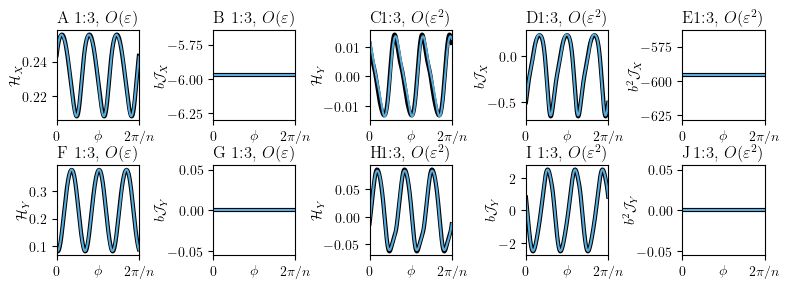

In [35]:
labels = ['A ','B ','C ','D ','E ','F ','G ','H' ,'I ','J ']
titles = [r'$O(\varepsilon)$',r'$O(\varepsilon)$',
          r'$O(\varepsilon^2)$',r'$O(\varepsilon^2)$',r'$O(\varepsilon^2)$',
         r'$O(\varepsilon)$',r'$O(\varepsilon)$',
          r'$O(\varepsilon^2)$',r'$O(\varepsilon^2)$',r'$O(\varepsilon^2)$']

pi_label_short = [r"$0$", r"$2\pi/n$"]
import matplotlib
matplotlib.rcParams['font.family'] = 'serif'
matplotlib.rcParams['text.usetex'] = True
matplotlib.rcParams['pgf.texsystem'] = 'pdflatex'
#matplotlib.rcParams['font.size'] = 12


preamble = (r'\usepackage{amsmath}'
            r'\usepackage{siunitx}'
            r'\usepackage{bm}'
            r'\newcommand{\ve}{\varepsilon}')

matplotlib.rcParams['text.latex.preamble'] = preamble
fontsize = 12

fig,axs = plt.subplots(2,5,figsize=(8,3))

axs[0,0].plot(a.x,a.system1.h['dat_hom'][0],color='k',lw=3)
axs[0,0].plot(a.x,tot1o1,label = 'Approx.',color='#57acdc')


axs[0,1].plot(a.x,a.system1.h['dat_het'][0][0],color='k',lw=3)
axs[0,1].plot(a.x,tot1o1c1+0*a.x,label = 'Approx.',color='#57acdc')

axs[0,2].plot(a.x,a.system1.h['dat_hom'][1],color='k',lw=3)
axs[0,2].plot(a.x,tot1o2,color='#57acdc')


axs[0,3].plot(a.x,a.system1.h['dat_het'][1][0],color='k',lw=3)
axs[0,3].plot(a.x,tot1o2c1+0*a.x,color='#57acdc')

axs[0,4].plot(a.x,a.system1.h['dat_het'][1][1],color='k',lw=3)
axs[0,4].plot(a.x,tot1o2c2+0*a.x,color='#57acdc')

axs[1,0].plot(a.x,a.system2.h['dat_hom'][0],color='k',lw=3)
axs[1,0].plot(a.x,tot2o1,color='#57acdc')

axs[1,1].plot(a.x,a.system2.h['dat_het'][0][0],color='k',lw=3)
axs[1,1].plot(a.x,tot2o1c1+0*a.x,color='#57acdc')

axs[1,2].plot(a.x,a.system2.h['dat_hom'][1],color='k',lw=3)
axs[1,2].plot(a.x,tot2o2,color='#57acdc')

axs[1,3].plot(a.x,a.system2.h['dat_het'][1][0],color='k',lw=3)
axs[1,3].plot(a.x,tot2o2c1+0*a.x,color='#57acdc')

axs[1,4].plot(a.x,a.system2.h['dat_het'][1][1],color='k',lw=3)
axs[1,4].plot(a.x,tot2o2c2+0*a.x,color='#57acdc')


axs = axs.flatten()
for k,label in enumerate(labels):
    axs[k].set_title(label,loc='left')
    axs[k].set_xticks([0,2*np.pi/a._n[1]])
    axs[k].set_xticklabels(pi_label_short)

    axs[k].set_xlabel(r'$\phi$',labelpad=-10);axs[k].set_xlim(0,2*np.pi/a._n[1])

    
    if k in [1,3]:
        axs[k].set_ylabel(r'$b\mathcal{J}_X$',labelpad=0)
    elif k in [6,8]:
        axs[k].set_ylabel(r'$b\mathcal{J}_Y$',labelpad=0)
    elif k in [4]:
        axs[k].set_ylabel(r'$b^2\mathcal{J}_X$',labelpad=0)
    elif k in [9]:
        axs[k].set_ylabel(r'$b^2\mathcal{J}_Y$',labelpad=0)
    elif k in [0,1]:
        axs[k].set_ylabel(r'$\mathcal{H}_X$',labelpad=0)
    else:
        axs[k].set_ylabel(r'$\mathcal{H}_Y$',labelpad=0)

    ti1 = axs[k].get_title()
    ti1 += r'$\quad$'+str(a._n[1])+':'+str(a._m[1])
    ti1 += ', '+titles[k]
        
    axs[k].set_title(ti1,loc='right')

# axs[0].legend()

plt.tight_layout()
plt.subplots_adjust(wspace=.9,hspace=.5)
plt.savefig('fourier{}{}.pdf'.format(a._n[1],a._m[1]))

#axs

# Initialize Coupling 3:1

In [36]:
#recompute_list = ['k_thal0_85','k_thal1_85','h_thal0_85','h_thal1_85', 'h_data_thal0_85','h_data_thal1_85', 'p_data_thal0_85','p_data_thal1_85','p_thal0_85','p_thal1_85']
# recompute_list = ['k_thal0_85','k_thal1_85']
recompute_list = []
kw_nm = {'system1':system1,'system2':system2,'_n':('om0',3),'_m':('om1',1),
         'NH':1024,'save_fig':False, 'recompute_list':recompute_list,
         'het_coeffs':[1,200], # [eps, eps^2, etc]
        }
a31 = nm.nmCoupling(**kw_nm)

Initializing 31 Coupling...
pfactor 30
* Loading p symbolic...
* Loading p symbolic...
p order=0
p order=0
* Loading H symbolic...
* Loading H symbolic...
* Loading H thal0_85, order=0...
* Loading H thal1_85, order=0...
* Loading H thal0_85, order=1...
* Loading H thal1_85, order=1...


## osc 1

### eps

In [37]:
a = a31
system = a.system1
data_hom = system.h['dat_hom'][0]
coeffs_re, coeffs_im, fr, fi = get_coeffs(data_hom,threshold=1)
tot1o1 = call_fourier_series(a,coeffs_re,coeffs_im,fr,fi)
print('')
print('hom osc 1 order 1',print_fourier_series_tex(a,coeffs_re,coeffs_im,fr,fi))

data_het = system.h['dat_het'][0][0]
coeffs_re, coeffs_im, fr, fi = get_coeffs(data_het,threshold=0)
tot1o1c1 = call_fourier_series(a,coeffs_re,coeffs_im,fr,fi)
print('')
print('het osc 1 order 1, c1',print_fourier_series_tex(a,coeffs_re,coeffs_im,fr,fi))


hom osc 1 order 1 0.2342-0.1437\cos(3x) -0.0047\cos(6x) +0.0370\sin(3x) 

het osc 1 order 1, c1 -5.9757


### eps^2

In [38]:
system = a.system1
data_hom = system.h['dat_hom'][1]
coeffs_re, coeffs_im, fr, fi = get_coeffs(data_hom,threshold=1)
tot1o2 = call_fourier_series(a,coeffs_re,coeffs_im,fr,fi)
print('')
print('hom osc 1 order 2',print_fourier_series_tex(a,coeffs_re,coeffs_im,fr,fi))

data_hets = system.h['dat_het'][1]

coeffs_re, coeffs_im, fr, fi = get_coeffs(data_hets[0],threshold=10)
tot1o2c1 = call_fourier_series(a,coeffs_re,coeffs_im,fr,fi)
print('')
print('het osc 1 order 2, c1',print_fourier_series_tex(a,coeffs_re,coeffs_im,fr,fi))

coeffs_re, coeffs_im, fr, fi = get_coeffs(data_hets[1],threshold=10)
tot1o2c2 = call_fourier_series(a,coeffs_re,coeffs_im,fr,fi)
print('')
print('het osc 1 order 2, c2',print_fourier_series_tex(a,coeffs_re,coeffs_im,fr,fi))


hom osc 1 order 2 0.0093-0.0147\cos(3x) -0.0020\cos(6x) -0.0045\cos(9x) -0.0715\sin(3x) +0.0067\sin(6x) 

het osc 1 order 2, c1 -0.1349-0.2452\cos(3x) -0.0203\cos(9x) -0.8977\sin(3x) -0.0673\sin(6x) +0.0272\sin(9x) 

het osc 1 order 2, c2 -1193.5286


## osc 2

### eps

In [39]:
system = a.system2
data_hom = system.h['dat_hom'][0]
coeffs_re, coeffs_im, fr, fi = get_coeffs(data_hom,threshold=1)
tot2o1 = call_fourier_series(a,coeffs_re,coeffs_im,fr,fi)
print('')
print('hom osc 2 order 1',print_fourier_series_tex(a,coeffs_re,coeffs_im,fr,fi))

data_het = system.h['dat_het'][0][0]
coeffs_re, coeffs_im, fr, fi = get_coeffs(data_het,threshold=0)
tot2o1c1 = call_fourier_series(a,coeffs_re,coeffs_im,fr,fi)
print('')
print('het osc 2  order 1, c1',print_fourier_series_tex(a,coeffs_re,coeffs_im,fr,fi))


hom osc 2 order 1 0.2342+0.0062\cos(3x) +0.0028\cos(6x) -0.0226\sin(3x) 

het osc 2  order 1, c1 


### eps^2

In [40]:
system = a.system2
data_hom = system.h['dat_hom'][1]
coeffs_re, coeffs_im, fr, fi = get_coeffs(data_hom,threshold=1)
tot2o2 = call_fourier_series(a,coeffs_re,coeffs_im,fr,fi)
print('')
print('hom osc 2 order 2',print_fourier_series_tex(a,coeffs_re,coeffs_im,fr,fi))

data_hets = system.h['dat_het'][1]

coeffs_re, coeffs_im, fr, fi = get_coeffs(data_hets[0],threshold=10)
tot2o2c1 = call_fourier_series(a,coeffs_re,coeffs_im,fr,fi)
print('')
print('het osc 2 order 2, c1',print_fourier_series_tex(a,coeffs_re,coeffs_im,fr,fi))

coeffs_re, coeffs_im, fr, fi = get_coeffs(data_hets[1],threshold=10)
tot2o2c2 = call_fourier_series(a,coeffs_re,coeffs_im,fr,fi)
print('')
print('het osc 2 order 2, c2',print_fourier_series_tex(a,coeffs_re,coeffs_im,fr,fi))


hom osc 2 order 2 +0.0126\cos(3x) +0.0027\sin(6x) 

het osc 2 order 2, c1 +0.1276\cos(3x) +0.0375\sin(3x) +0.0312\sin(6x) 

het osc 2 order 2, c2 


## Plot

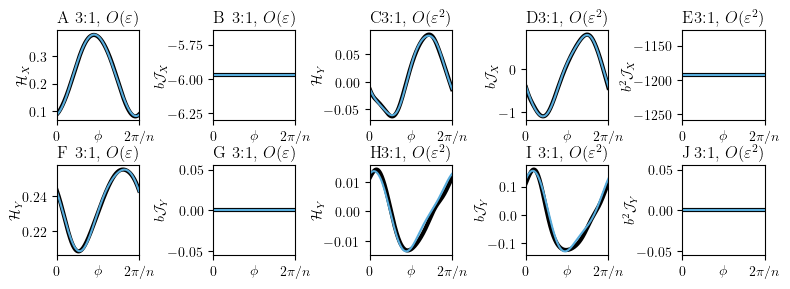

In [41]:
labels = ['A ','B ','C ','D ','E ','F ','G ','H' ,'I ','J ']
titles = [r'$O(\varepsilon)$',r'$O(\varepsilon)$',
          r'$O(\varepsilon^2)$',r'$O(\varepsilon^2)$',r'$O(\varepsilon^2)$',
         r'$O(\varepsilon)$',r'$O(\varepsilon)$',
          r'$O(\varepsilon^2)$',r'$O(\varepsilon^2)$',r'$O(\varepsilon^2)$']

pi_label_short = [r"$0$", r"$2\pi/n$"]
import matplotlib
matplotlib.rcParams['font.family'] = 'serif'
matplotlib.rcParams['text.usetex'] = True
matplotlib.rcParams['pgf.texsystem'] = 'pdflatex'
#matplotlib.rcParams['font.size'] = 12


preamble = (r'\usepackage{amsmath}'
            r'\usepackage{siunitx}'
            r'\usepackage{bm}'
            r'\newcommand{\ve}{\varepsilon}')

matplotlib.rcParams['text.latex.preamble'] = preamble
fontsize = 12

fig,axs = plt.subplots(2,5,figsize=(8,3))

axs[0,0].plot(a.x,a.system1.h['dat_hom'][0],color='k',lw=3)
axs[0,0].plot(a.x,tot1o1,label = 'Approx.',color='#57acdc')


axs[0,1].plot(a.x,a.system1.h['dat_het'][0][0],color='k',lw=3)
axs[0,1].plot(a.x,tot1o1c1+0*a.x,label = 'Approx.',color='#57acdc')

axs[0,2].plot(a.x,a.system1.h['dat_hom'][1],color='k',lw=3)
axs[0,2].plot(a.x,tot1o2,color='#57acdc')


axs[0,3].plot(a.x,a.system1.h['dat_het'][1][0],color='k',lw=3)
axs[0,3].plot(a.x,tot1o2c1+0*a.x,color='#57acdc')

axs[0,4].plot(a.x,a.system1.h['dat_het'][1][1],color='k',lw=3)
axs[0,4].plot(a.x,tot1o2c2+0*a.x,color='#57acdc')

axs[1,0].plot(a.x,a.system2.h['dat_hom'][0],color='k',lw=3)
axs[1,0].plot(a.x,tot2o1,color='#57acdc')

axs[1,1].plot(a.x,a.system2.h['dat_het'][0][0],color='k',lw=3)
axs[1,1].plot(a.x,tot2o1c1+0*a.x,color='#57acdc')

axs[1,2].plot(a.x,a.system2.h['dat_hom'][1],color='k',lw=3)
axs[1,2].plot(a.x,tot2o2,color='#57acdc')

axs[1,3].plot(a.x,a.system2.h['dat_het'][1][0],color='k',lw=3)
axs[1,3].plot(a.x,tot2o2c1+0*a.x,color='#57acdc')

axs[1,4].plot(a.x,a.system2.h['dat_het'][1][1],color='k',lw=3)
axs[1,4].plot(a.x,tot2o2c2+0*a.x,color='#57acdc')


axs = axs.flatten()
for k,label in enumerate(labels):
    axs[k].set_title(label,loc='left')
    axs[k].set_xticks([0,2*np.pi/a._n[1]])
    axs[k].set_xticklabels(pi_label_short)
    
    axs[k].set_xlabel(r'$\phi$',labelpad=-10);axs[k].set_xlim(0,2*np.pi/a._n[1])

    
    if k in [1,3]:
        axs[k].set_ylabel(r'$b\mathcal{J}_X$',labelpad=0)
    elif k in [6,8]:
        axs[k].set_ylabel(r'$b\mathcal{J}_Y$',labelpad=0)
    elif k in [4]:
        axs[k].set_ylabel(r'$b^2\mathcal{J}_X$',labelpad=0)
    elif k in [9]:
        axs[k].set_ylabel(r'$b^2\mathcal{J}_Y$',labelpad=0)
    elif k in [0,1]:
        axs[k].set_ylabel(r'$\mathcal{H}_X$',labelpad=0)
    else:
        axs[k].set_ylabel(r'$\mathcal{H}_Y$',labelpad=0)

    ti1 = axs[k].get_title()
    ti1 += r'$\quad$'+str(a._n[1])+':'+str(a._m[1])
    ti1 += ', '+titles[k]
        
    axs[k].set_title(ti1,loc='right')

# axs[0].legend()

plt.tight_layout()
plt.subplots_adjust(wspace=.9,hspace=.5)
plt.savefig('fourier{}{}.pdf'.format(a._n[1],a._m[1]))

#axs

# Initialize Coupling 2:3

In [42]:
#recompute_list = ['k_thal0_85','k_thal1_85','h_thal0_85','h_thal1_85', 'h_data_thal0_85','h_data_thal1_85', 'p_data_thal0_85','p_data_thal1_85','p_thal0_85','p_thal1_85']
# recompute_list = ['k_thal0_85','k_thal1_85']
recompute_list = []
kw_nm = {'system1':system1,'system2':system2,'_n':('om0',2),'_m':('om1',3),
         'NH':1024,'save_fig':False, 'recompute_list':recompute_list,
         'het_coeffs':[1,2000], # [eps, eps^2, etc]
        }
a23 = nm.nmCoupling(**kw_nm)

Initializing 23 Coupling...
pfactor 30
* Loading p symbolic...
* Loading p symbolic...
p order=0
p order=0
* Loading H symbolic...
* Loading H symbolic...
* Loading H thal0_85, order=0...
* Loading H thal1_85, order=0...
* Loading H thal0_85, order=1...
* Loading H thal1_85, order=1...


## osc 1

### eps

In [43]:
a = a23
system = a.system1
data_hom = system.h['dat_hom'][0]
coeffs_re, coeffs_im, fr, fi = get_coeffs(data_hom,threshold=1)
tot1o1 = call_fourier_series(a,coeffs_re,coeffs_im,fr,fi)
print('')
print('hom osc 1 order 1',print_fourier_series_tex(a,coeffs_re,coeffs_im,fr,fi))

data_het = system.h['dat_het'][0][0]
coeffs_re, coeffs_im, fr, fi = get_coeffs(data_het,threshold=0)
tot1o1c1 = call_fourier_series(a,coeffs_re,coeffs_im,fr,fi)
print('')
print('het osc 1 order 1, c1',print_fourier_series_tex(a,coeffs_re,coeffs_im,fr,fi))


hom osc 1 order 1 0.2342+0.0098\cos(6x) +0.0149\sin(6x) 

het osc 1 order 1, c1 -5.9757


### eps^2

In [44]:
system = a.system1
data_hom = system.h['dat_hom'][1]
coeffs_re, coeffs_im, fr, fi = get_coeffs(data_hom,threshold=1)
tot1o2 = call_fourier_series(a,coeffs_re,coeffs_im,fr,fi)
print('')
print('hom osc 1 order 2',print_fourier_series_tex(a,coeffs_re,coeffs_im,fr,fi))

data_hets = system.h['dat_het'][1]

coeffs_re, coeffs_im, fr, fi = get_coeffs(data_hets[0],threshold=10)
tot1o2c1 = call_fourier_series(a,coeffs_re,coeffs_im,fr,fi)
print('')
print('het osc 1 order 2, c1',print_fourier_series_tex(a,coeffs_re,coeffs_im,fr,fi))

coeffs_re, coeffs_im, fr, fi = get_coeffs(data_hets[1],threshold=10)
tot1o2c2 = call_fourier_series(a,coeffs_re,coeffs_im,fr,fi)
print('')
print('het osc 1 order 2, c2',print_fourier_series_tex(a,coeffs_re,coeffs_im,fr,fi))


hom osc 1 order 2 0.0014+0.0075\cos(6x) -0.0039\sin(6x) -0.0028\sin(12x) 

het osc 1 order 2, c1 -0.1346-0.2507\cos(6x) +0.1866\sin(6x) +0.0516\sin(12x) 

het osc 1 order 2, c2 -11949.8445


## osc 2

### eps

In [45]:
system = a.system2
data_hom = system.h['dat_hom'][0]
coeffs_re, coeffs_im, fr, fi = get_coeffs(data_hom,threshold=1)
tot2o1 = call_fourier_series(a,coeffs_re,coeffs_im,fr,fi)
print('')
print('hom osc 2 order 1',print_fourier_series_tex(a,coeffs_re,coeffs_im,fr,fi))

data_het = system.h['dat_het'][0][0]
coeffs_re, coeffs_im, fr, fi = get_coeffs(data_het,threshold=0)
tot2o1c1 = call_fourier_series(a,coeffs_re,coeffs_im,fr,fi)
print('')
print('het osc 2 order 1, c1',print_fourier_series_tex(a,coeffs_re,coeffs_im,fr,fi))


hom osc 2 order 1 0.2342-0.0122\cos(6x) +0.0030\cos(12x) -0.0022\sin(6x) 

het osc 2 order 1, c1 


### eps^2

In [46]:
system = a.system2
data_hom = system.h['dat_hom'][1]
coeffs_re, coeffs_im, fr, fi = get_coeffs(data_hom,threshold=1)
tot2o2 = call_fourier_series(a,coeffs_re,coeffs_im,fr,fi)
print('')
print('hom osc 2 order 2',print_fourier_series_tex(a,coeffs_re,coeffs_im,fr,fi))

data_hets = system.h['dat_het'][1]

coeffs_re, coeffs_im, fr, fi = get_coeffs(data_hets[0],threshold=10)
tot2o2c1 = call_fourier_series(a,coeffs_re,coeffs_im,fr,fi)
print('')
print('het osc 2 order 2, c1',print_fourier_series_tex(a,coeffs_re,coeffs_im,fr,fi))

coeffs_re, coeffs_im, fr, fi = get_coeffs(data_hets[1],threshold=10)
tot2o2c2 = call_fourier_series(a,coeffs_re,coeffs_im,fr,fi)
print('')
print('het osc 2 order 2, c2',print_fourier_series_tex(a,coeffs_re,coeffs_im,fr,fi))


hom osc 2 order 2 0.0024+0.0040\sin(6x) 

het osc 2 order 2, c1 +0.0378\cos(6x) +0.0623\cos(12x) -0.2033\sin(6x) +0.0992\sin(12x) 

het osc 2 order 2, c2 


## Plot

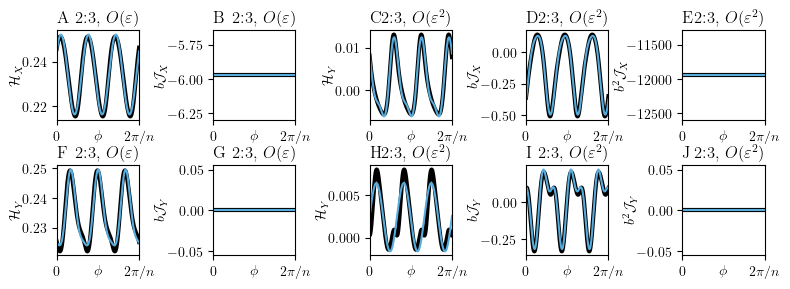

In [47]:
labels = ['A ','B ','C ','D ','E ','F ','G ','H' ,'I ','J ']
titles = [r'$O(\varepsilon)$',r'$O(\varepsilon)$',
          r'$O(\varepsilon^2)$',r'$O(\varepsilon^2)$',r'$O(\varepsilon^2)$',
         r'$O(\varepsilon)$',r'$O(\varepsilon)$',
          r'$O(\varepsilon^2)$',r'$O(\varepsilon^2)$',r'$O(\varepsilon^2)$']

pi_label_short = [r"$0$", r"$2\pi/n$"]
import matplotlib
matplotlib.rcParams['font.family'] = 'serif'
matplotlib.rcParams['text.usetex'] = True
matplotlib.rcParams['pgf.texsystem'] = 'pdflatex'
#matplotlib.rcParams['font.size'] = 12


preamble = (r'\usepackage{amsmath}'
            r'\usepackage{siunitx}'
            r'\usepackage{bm}'
            r'\newcommand{\ve}{\varepsilon}')

matplotlib.rcParams['text.latex.preamble'] = preamble
fontsize = 12

fig,axs = plt.subplots(2,5,figsize=(8,3))

axs[0,0].plot(a.x,a.system1.h['dat_hom'][0],color='k',lw=3)
axs[0,0].plot(a.x,tot1o1,label = 'Approx.',color='#57acdc')


axs[0,1].plot(a.x,a.system1.h['dat_het'][0][0],color='k',lw=3)
axs[0,1].plot(a.x,tot1o1c1+0*a.x,label = 'Approx.',color='#57acdc')

axs[0,2].plot(a.x,a.system1.h['dat_hom'][1],color='k',lw=3)
axs[0,2].plot(a.x,tot1o2,color='#57acdc')


axs[0,3].plot(a.x,a.system1.h['dat_het'][1][0],color='k',lw=3)
axs[0,3].plot(a.x,tot1o2c1+0*a.x,color='#57acdc')

axs[0,4].plot(a.x,a.system1.h['dat_het'][1][1],color='k',lw=3)
axs[0,4].plot(a.x,tot1o2c2+0*a.x,color='#57acdc')

axs[1,0].plot(a.x,a.system2.h['dat_hom'][0],color='k',lw=3)
axs[1,0].plot(a.x,tot2o1,color='#57acdc')

axs[1,1].plot(a.x,a.system2.h['dat_het'][0][0],color='k',lw=3)
axs[1,1].plot(a.x,tot2o1c1+0*a.x,color='#57acdc')

axs[1,2].plot(a.x,a.system2.h['dat_hom'][1],color='k',lw=3)
axs[1,2].plot(a.x,tot2o2,color='#57acdc')

axs[1,3].plot(a.x,a.system2.h['dat_het'][1][0],color='k',lw=3)
axs[1,3].plot(a.x,tot2o2c1+0*a.x,color='#57acdc')

axs[1,4].plot(a.x,a.system2.h['dat_het'][1][1],color='k',lw=3)
axs[1,4].plot(a.x,tot2o2c2+0*a.x,color='#57acdc')


axs = axs.flatten()
for k,label in enumerate(labels):
    axs[k].set_title(label,loc='left')
    axs[k].set_xticks([0,2*np.pi/a._n[1]])
    axs[k].set_xticklabels(pi_label_short)

    axs[k].set_xlabel(r'$\phi$',labelpad=-10);axs[k].set_xlim(0,2*np.pi/a._n[1])

    
    if k in [1,3]:
        axs[k].set_ylabel(r'$b\mathcal{J}_X$',labelpad=0)
    elif k in [6,8]:
        axs[k].set_ylabel(r'$b\mathcal{J}_Y$',labelpad=0)
    elif k in [4]:
        axs[k].set_ylabel(r'$b^2\mathcal{J}_X$',labelpad=0)
    elif k in [9]:
        axs[k].set_ylabel(r'$b^2\mathcal{J}_Y$',labelpad=0)
    elif k in [0,1]:
        axs[k].set_ylabel(r'$\mathcal{H}_X$',labelpad=0)
    else:
        axs[k].set_ylabel(r'$\mathcal{H}_Y$',labelpad=0)

    ti1 = axs[k].get_title()
    ti1 += r'$\quad$'+str(a._n[1])+':'+str(a._m[1])
    ti1 += ', '+titles[k]
        
    axs[k].set_title(ti1,loc='right')

# axs[0].legend()

axs[4].ticklabel_format(axis='y', style='sci')

plt.tight_layout()
plt.subplots_adjust(wspace=.9,hspace=.5)
plt.savefig('fourier{}{}.pdf'.format(a._n[1],a._m[1]))

#axs

# Initialize Coupling 3:2

In [48]:
#recompute_list = ['k_thal0_85','k_thal1_85','h_thal0_85','h_thal1_85', 'h_data_thal0_85','h_data_thal1_85', 'p_data_thal0_85','p_data_thal1_85','p_thal0_85','p_thal1_85']
# recompute_list = ['k_thal0_85','k_thal1_85']
recompute_list = []
kw_nm = {'system1':system1,'system2':system2,'_n':('om0',3),'_m':('om1',2),
         'NH':1024,'save_fig':False, 'recompute_list':recompute_list,
         'het_coeffs':[1,500], # [eps, eps^2, etc]
        }
a32 = nm.nmCoupling(**kw_nm)

Initializing 32 Coupling...
pfactor 30
* Loading p symbolic...
* Loading p symbolic...
p order=0
p order=0
* Loading H symbolic...
* Loading H symbolic...
* Loading H thal0_85, order=0...
* Loading H thal1_85, order=0...
* Loading H thal0_85, order=1...
* Loading H thal1_85, order=1...


## osc 1

### eps

In [49]:
a = a32
system = a.system1
data_hom = system.h['dat_hom'][0]
coeffs_re, coeffs_im, fr, fi = get_coeffs(data_hom,threshold=1)
tot1o1 = call_fourier_series(a,coeffs_re,coeffs_im,fr,fi)
print('')
print('hom osc 1 order 1',print_fourier_series_tex(a,coeffs_re,coeffs_im,fr,fi))

data_het = system.h['dat_het'][0][0]
coeffs_re, coeffs_im, fr, fi = get_coeffs(data_het,threshold=0)
tot1o1c1 = call_fourier_series(a,coeffs_re,coeffs_im,fr,fi)
print('')
print('het osc 1 order 1, c1',print_fourier_series_tex(a,coeffs_re,coeffs_im,fr,fi))


hom osc 1 order 1 0.2342-0.0122\cos(6x) +0.0030\cos(12x) +0.0022\sin(6x) 

het osc 1 order 1, c1 -5.9757


### eps^2

In [50]:
system = a.system1
data_hom = system.h['dat_hom'][1]
coeffs_re, coeffs_im, fr, fi = get_coeffs(data_hom,threshold=1)
tot1o2 = call_fourier_series(a,coeffs_re,coeffs_im,fr,fi)
print('')
print('hom osc 1 order 2',print_fourier_series_tex(a,coeffs_re,coeffs_im,fr,fi))

data_hets = system.h['dat_het'][1]

coeffs_re, coeffs_im, fr, fi = get_coeffs(data_hets[0],threshold=10)
tot1o2c1 = call_fourier_series(a,coeffs_re,coeffs_im,fr,fi)
print('')
print('het osc 1 order 2, c1',print_fourier_series_tex(a,coeffs_re,coeffs_im,fr,fi))

coeffs_re, coeffs_im, fr, fi = get_coeffs(data_hets[1],threshold=10)
tot1o2c2 = call_fourier_series(a,coeffs_re,coeffs_im,fr,fi)
print('')
print('het osc 1 order 2, c2',print_fourier_series_tex(a,coeffs_re,coeffs_im,fr,fi))


hom osc 1 order 2 0.0024-0.0040\sin(6x) 

het osc 1 order 2, c1 -0.1349-0.0424\cos(12x) -0.1655\sin(6x) +0.0695\sin(12x) 

het osc 1 order 2, c2 -11949.8408


## osc 2

### eps

In [51]:
system = a.system2
data_hom = system.h['dat_hom'][0]
coeffs_re, coeffs_im, fr, fi = get_coeffs(data_hom,threshold=1)
tot2o1 = call_fourier_series(a,coeffs_re,coeffs_im,fr,fi)
print('')
print('hom osc 2 order 1',print_fourier_series_tex(a,coeffs_re,coeffs_im,fr,fi))

data_het = system.h['dat_het'][0][0]
coeffs_re, coeffs_im, fr, fi = get_coeffs(data_het,threshold=0)
tot2o1c1 = call_fourier_series(a,coeffs_re,coeffs_im,fr,fi)
print('')
print('het osc 2 order 1, c1',print_fourier_series_tex(a,coeffs_re,coeffs_im,fr,fi))


hom osc 2 order 1 0.2342+0.0098\cos(6x) -0.0149\sin(6x) 

het osc 2 order 1, c1 


### eps^2

In [52]:
system = a.system2
data_hom = system.h['dat_hom'][1]
coeffs_re, coeffs_im, fr, fi = get_coeffs(data_hom,threshold=1)
tot2o2 = call_fourier_series(a,coeffs_re,coeffs_im,fr,fi)
print('')
print('hom osc 2 order 2',print_fourier_series_tex(a,coeffs_re,coeffs_im,fr,fi))

data_hets = system.h['dat_het'][1]

coeffs_re, coeffs_im, fr, fi = get_coeffs(data_hets[0],threshold=10)
tot2o2c1 = call_fourier_series(a,coeffs_re,coeffs_im,fr,fi)
print('')
print('het osc 2 order 2, c1',print_fourier_series_tex(a,coeffs_re,coeffs_im,fr,fi))

coeffs_re, coeffs_im, fr, fi = get_coeffs(data_hets[1],threshold=10)
tot2o2c2 = call_fourier_series(a,coeffs_re,coeffs_im,fr,fi)
print('')
print('het osc 2 order 2, c2',print_fourier_series_tex(a,coeffs_re,coeffs_im,fr,fi))


hom osc 2 order 2 0.0014+0.0075\cos(6x) +0.0039\sin(6x) +0.0028\sin(12x) 

het osc 2 order 2, c1 +0.1659\cos(6x) +0.1126\sin(6x) +0.0339\sin(12x) 

het osc 2 order 2, c2 


## Plot

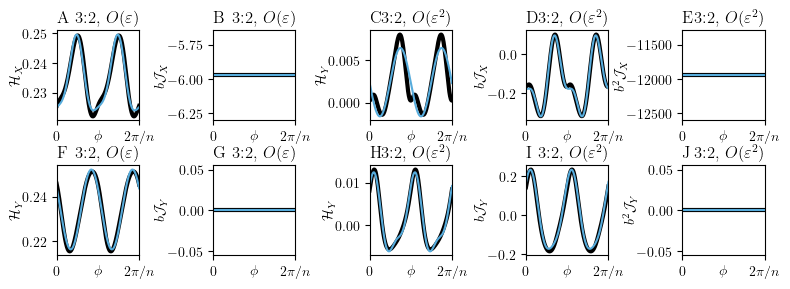

In [53]:
labels = ['A ','B ','C ','D ','E ','F ','G ','H' ,'I ','J ']
titles = [r'$O(\varepsilon)$',r'$O(\varepsilon)$',
          r'$O(\varepsilon^2)$',r'$O(\varepsilon^2)$',r'$O(\varepsilon^2)$',
         r'$O(\varepsilon)$',r'$O(\varepsilon)$',
          r'$O(\varepsilon^2)$',r'$O(\varepsilon^2)$',r'$O(\varepsilon^2)$']

pi_label_short = [r"$0$", r"$2\pi/n$"]
import matplotlib
matplotlib.rcParams['font.family'] = 'serif'
matplotlib.rcParams['text.usetex'] = True
matplotlib.rcParams['pgf.texsystem'] = 'pdflatex'
#matplotlib.rcParams['font.size'] = 12


preamble = (r'\usepackage{amsmath}'
            r'\usepackage{siunitx}'
            r'\usepackage{bm}'
            r'\newcommand{\ve}{\varepsilon}')

matplotlib.rcParams['text.latex.preamble'] = preamble
fontsize = 12

fig,axs = plt.subplots(2,5,figsize=(8,3))

axs[0,0].plot(a.x,a.system1.h['dat_hom'][0],color='k',lw=3)
axs[0,0].plot(a.x,tot1o1,label = 'Approx.',color='#57acdc')


axs[0,1].plot(a.x,a.system1.h['dat_het'][0][0],color='k',lw=3)
axs[0,1].plot(a.x,tot1o1c1+0*a.x,label = 'Approx.',color='#57acdc')

axs[0,2].plot(a.x,a.system1.h['dat_hom'][1],color='k',lw=3)
axs[0,2].plot(a.x,tot1o2,color='#57acdc')


axs[0,3].plot(a.x,a.system1.h['dat_het'][1][0],color='k',lw=3)
axs[0,3].plot(a.x,tot1o2c1+0*a.x,color='#57acdc')

axs[0,4].plot(a.x,a.system1.h['dat_het'][1][1],color='k',lw=3)
axs[0,4].plot(a.x,tot1o2c2+0*a.x,color='#57acdc')

axs[1,0].plot(a.x,a.system2.h['dat_hom'][0],color='k',lw=3)
axs[1,0].plot(a.x,tot2o1,color='#57acdc')

axs[1,1].plot(a.x,a.system2.h['dat_het'][0][0],color='k',lw=3)
axs[1,1].plot(a.x,tot2o1c1+0*a.x,color='#57acdc')

axs[1,2].plot(a.x,a.system2.h['dat_hom'][1],color='k',lw=3)
axs[1,2].plot(a.x,tot2o2,color='#57acdc')

axs[1,3].plot(a.x,a.system2.h['dat_het'][1][0],color='k',lw=3)
axs[1,3].plot(a.x,tot2o2c1+0*a.x,color='#57acdc')

axs[1,4].plot(a.x,a.system2.h['dat_het'][1][1],color='k',lw=3)
axs[1,4].plot(a.x,tot2o2c2+0*a.x,color='#57acdc')


axs = axs.flatten()
for k,label in enumerate(labels):
    axs[k].set_title(label,loc='left')
    axs[k].set_xticks([0,2*np.pi/a._n[1]])
    axs[k].set_xticklabels(pi_label_short)

    axs[k].set_xlabel(r'$\phi$',labelpad=-10);axs[k].set_xlim(0,2*np.pi/a._n[1])

    
    if k in [1,3]:
        axs[k].set_ylabel(r'$b\mathcal{J}_X$',labelpad=0)
    elif k in [6,8]:
        axs[k].set_ylabel(r'$b\mathcal{J}_Y$',labelpad=0)
    elif k in [4]:
        axs[k].set_ylabel(r'$b^2\mathcal{J}_X$',labelpad=0)
    elif k in [9]:
        axs[k].set_ylabel(r'$b^2\mathcal{J}_Y$',labelpad=0)
    elif k in [0,1]:
        axs[k].set_ylabel(r'$\mathcal{H}_X$',labelpad=0)
    else:
        axs[k].set_ylabel(r'$\mathcal{H}_Y$',labelpad=0)

    ti1 = axs[k].get_title()
    ti1 += r'$\quad$'+str(a._n[1])+':'+str(a._m[1])
    ti1 += ', '+titles[k]
        
    axs[k].set_title(ti1,loc='right')

#axs[4].ticklabel_format(axis='y', style='sci')

#axs[4].ticklabel_format(axis='y', style='sci')
# axs[0].legend()

plt.tight_layout()
plt.subplots_adjust(wspace=.9,hspace=.5)
plt.savefig('fourier{}{}.pdf'.format(a._n[1],a._m[1]))

#axs

# Initialize Coupling 3:4

In [54]:
#recompute_list = ['k_thal0_85','k_thal1_85','h_thal0_85','h_thal1_85', 'h_data_thal0_85','h_data_thal1_85', 'p_data_thal0_85','p_data_thal1_85','p_thal0_85','p_thal1_85']
# recompute_list = ['k_thal0_85','k_thal1_85']
recompute_list = []
kw_nm = {'system1':system1,'system2':system2,'_n':('om0',3),'_m':('om1',4),
         'NH':1024,'save_fig':False, 'recompute_list':recompute_list,
         'het_coeffs':[1,1000], # [eps, eps^2, etc]
        }
a34 = nm.nmCoupling(**kw_nm)

Initializing 34 Coupling...
pfactor 30
* Loading p symbolic...
* Loading p symbolic...
p order=0
p order=0
* Loading H symbolic...
* Loading H symbolic...
* Loading H thal0_85, order=0...
* Loading H thal1_85, order=0...
* Loading H thal0_85, order=1...
* Loading H thal1_85, order=1...


## osc 1

### eps

In [55]:
a = a34
system = a.system1
data_hom = system.h['dat_hom'][0]
coeffs_re, coeffs_im, fr, fi = get_coeffs(data_hom,threshold=1)
tot1o1 = call_fourier_series(a,coeffs_re,coeffs_im,fr,fi)
print('')
print('hom osc 1 order 1',print_fourier_series_tex(a,coeffs_re,coeffs_im,fr,fi))

data_het = system.h['dat_het'][0][0]
coeffs_re, coeffs_im, fr, fi = get_coeffs(data_het,threshold=0)
tot1o1c1 = call_fourier_series(a,coeffs_re,coeffs_im,fr,fi)
print('')
print('het osc 1 order 1, c1',print_fourier_series_tex(a,coeffs_re,coeffs_im,fr,fi))


hom osc 1 order 1 0.2342+0.0062\cos(12x) +0.0059\sin(12x) 

het osc 1 order 1, c1 -5.9757


### eps^2

In [56]:
system = a.system1
data_hom = system.h['dat_hom'][1]
coeffs_re, coeffs_im, fr, fi = get_coeffs(data_hom,threshold=1)
tot1o2 = call_fourier_series(a,coeffs_re,coeffs_im,fr,fi)
print('')
print('hom osc 1 order 2',print_fourier_series_tex(a,coeffs_re,coeffs_im,fr,fi))

data_hets = system.h['dat_het'][1]

coeffs_re, coeffs_im, fr, fi = get_coeffs(data_hets[0],threshold=10)
tot1o2c1 = call_fourier_series(a,coeffs_re,coeffs_im,fr,fi)
print('')
print('het osc 1 order 2, c1',print_fourier_series_tex(a,coeffs_re,coeffs_im,fr,fi))

coeffs_re, coeffs_im, fr, fi = get_coeffs(data_hets[1],threshold=10)
tot1o2c2 = call_fourier_series(a,coeffs_re,coeffs_im,fr,fi)
print('')
print('het osc 1 order 2, c2',print_fourier_series_tex(a,coeffs_re,coeffs_im,fr,fi))


hom osc 1 order 2 +0.0035\cos(12x) -0.0040\sin(12x) 

het osc 1 order 2, c1 -0.1349-0.1352\cos(12x) +0.1448\sin(12x) 

het osc 1 order 2, c2 -5974.1118


## osc 2

### eps

In [57]:
system = a.system2
data_hom = system.h['dat_hom'][0]
coeffs_re, coeffs_im, fr, fi = get_coeffs(data_hom,threshold=1)
tot2o1 = call_fourier_series(a,coeffs_re,coeffs_im,fr,fi)
print('')
print('hom osc 2 order 1',print_fourier_series_tex(a,coeffs_re,coeffs_im,fr,fi))

data_het = system.h['dat_het'][0][0]
coeffs_re, coeffs_im, fr, fi = get_coeffs(data_het,threshold=0)
tot2o1c1 = call_fourier_series(a,coeffs_re,coeffs_im,fr,fi)
print('')
print('het osc 2 order 1, c1',print_fourier_series_tex(a,coeffs_re,coeffs_im,fr,fi))


hom osc 2 order 1 0.2342+0.0076\cos(12x) -0.0063\sin(12x) 

het osc 2 order 1, c1 


### eps^2

In [58]:
system = a.system2
data_hom = system.h['dat_hom'][1]
coeffs_re, coeffs_im, fr, fi = get_coeffs(data_hom,threshold=1)
tot2o2 = call_fourier_series(a,coeffs_re,coeffs_im,fr,fi)
print('')
print('hom osc 2 order 2',print_fourier_series_tex(a,coeffs_re,coeffs_im,fr,fi))

data_hets = system.h['dat_het'][1]

coeffs_re, coeffs_im, fr, fi = get_coeffs(data_hets[0],threshold=10)
tot2o2c1 = call_fourier_series(a,coeffs_re,coeffs_im,fr,fi)
print('')
print('het osc 2 order 2, c1',print_fourier_series_tex(a,coeffs_re,coeffs_im,fr,fi))

coeffs_re, coeffs_im, fr, fi = get_coeffs(data_hets[1],threshold=10)
tot2o2c2 = call_fourier_series(a,coeffs_re,coeffs_im,fr,fi)
print('')
print('het osc 2 order 2, c2',print_fourier_series_tex(a,coeffs_re,coeffs_im,fr,fi))


hom osc 2 order 2 0.0049-0.0030\cos(12x) 

het osc 2 order 2, c1 +0.1398\cos(12x) +0.1691\sin(12x) 

het osc 2 order 2, c2 


## Plot

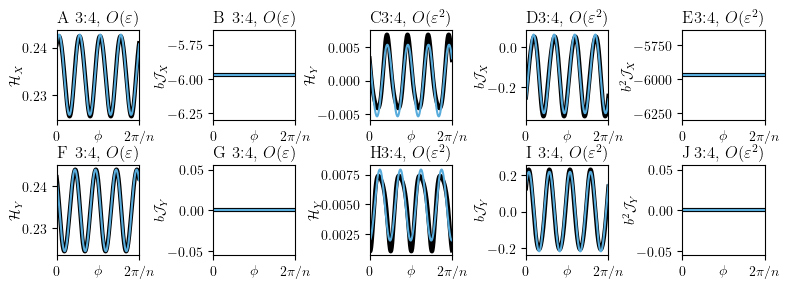

In [59]:
labels = ['A ','B ','C ','D ','E ','F ','G ','H' ,'I ','J ']
titles = [r'$O(\varepsilon)$',r'$O(\varepsilon)$',
          r'$O(\varepsilon^2)$',r'$O(\varepsilon^2)$',r'$O(\varepsilon^2)$',
         r'$O(\varepsilon)$',r'$O(\varepsilon)$',
          r'$O(\varepsilon^2)$',r'$O(\varepsilon^2)$',r'$O(\varepsilon^2)$']

pi_label_short = [r"$0$", r"$2\pi/n$"]
import matplotlib
matplotlib.rcParams['font.family'] = 'serif'
matplotlib.rcParams['text.usetex'] = True
matplotlib.rcParams['pgf.texsystem'] = 'pdflatex'
#matplotlib.rcParams['font.size'] = 12


preamble = (r'\usepackage{amsmath}'
            r'\usepackage{siunitx}'
            r'\usepackage{bm}'
            r'\newcommand{\ve}{\varepsilon}')

matplotlib.rcParams['text.latex.preamble'] = preamble
fontsize = 12

fig,axs = plt.subplots(2,5,figsize=(8,3))

axs[0,0].plot(a.x,a.system1.h['dat_hom'][0],color='k',lw=3)
axs[0,0].plot(a.x,tot1o1,label = 'Approx.',color='#57acdc')


axs[0,1].plot(a.x,a.system1.h['dat_het'][0][0],color='k',lw=3)
axs[0,1].plot(a.x,tot1o1c1+0*a.x,label = 'Approx.',color='#57acdc')

axs[0,2].plot(a.x,a.system1.h['dat_hom'][1],color='k',lw=3)
axs[0,2].plot(a.x,tot1o2,color='#57acdc')


axs[0,3].plot(a.x,a.system1.h['dat_het'][1][0],color='k',lw=3)
axs[0,3].plot(a.x,tot1o2c1+0*a.x,color='#57acdc')

axs[0,4].plot(a.x,a.system1.h['dat_het'][1][1],color='k',lw=3)
axs[0,4].plot(a.x,tot1o2c2+0*a.x,color='#57acdc')

axs[1,0].plot(a.x,a.system2.h['dat_hom'][0],color='k',lw=3)
axs[1,0].plot(a.x,tot2o1,color='#57acdc')

axs[1,1].plot(a.x,a.system2.h['dat_het'][0][0],color='k',lw=3)
axs[1,1].plot(a.x,tot2o1c1+0*a.x,color='#57acdc')

axs[1,2].plot(a.x,a.system2.h['dat_hom'][1],color='k',lw=3)
axs[1,2].plot(a.x,tot2o2,color='#57acdc')

axs[1,3].plot(a.x,a.system2.h['dat_het'][1][0],color='k',lw=3)
axs[1,3].plot(a.x,tot2o2c1+0*a.x,color='#57acdc')

axs[1,4].plot(a.x,a.system2.h['dat_het'][1][1],color='k',lw=3)
axs[1,4].plot(a.x,tot2o2c2+0*a.x,color='#57acdc')


axs = axs.flatten()
for k,label in enumerate(labels):
    axs[k].set_title(label,loc='left')
    axs[k].set_xticks([0,2*np.pi/a._n[1]])
    axs[k].set_xticklabels(pi_label_short)

    axs[k].set_xlabel(r'$\phi$',labelpad=-10);axs[k].set_xlim(0,2*np.pi/a._n[1])

    
    if k in [1,3]:
        axs[k].set_ylabel(r'$b\mathcal{J}_X$',labelpad=0)
    elif k in [6,8]:
        axs[k].set_ylabel(r'$b\mathcal{J}_Y$',labelpad=0)
    elif k in [4]:
        axs[k].set_ylabel(r'$b^2\mathcal{J}_X$',labelpad=0)
    elif k in [9]:
        axs[k].set_ylabel(r'$b^2\mathcal{J}_Y$',labelpad=0)
    elif k in [0,1]:
        axs[k].set_ylabel(r'$\mathcal{H}_X$',labelpad=0)
    else:
        axs[k].set_ylabel(r'$\mathcal{H}_Y$',labelpad=0)

    ti1 = axs[k].get_title()
    ti1 += r'$\quad$'+str(a._n[1])+':'+str(a._m[1])
    ti1 += ', '+titles[k]
        
    axs[k].set_title(ti1,loc='right')

# axs[0].legend()

plt.tight_layout()
plt.subplots_adjust(wspace=.9,hspace=.5)
plt.savefig('fourier{}{}.pdf'.format(a._n[1],a._m[1]))

#axs

# Initialize Coupling 4:3

In [60]:
#recompute_list = ['k_thal0_85','k_thal1_85','h_thal0_85','h_thal1_85', 'h_data_thal0_85','h_data_thal1_85', 'p_data_thal0_85','p_data_thal1_85','p_thal0_85','p_thal1_85']
# recompute_list = ['k_thal0_85','k_thal1_85']
recompute_list = []
kw_nm = {'system1':system1,'system2':system2,'_n':('om0',4),'_m':('om1',3),
         'NH':1024,'save_fig':False, 'recompute_list':recompute_list,
         'het_coeffs':[1,1000], # [eps, eps^2, etc]
        }
a43 = nm.nmCoupling(**kw_nm)

Initializing 43 Coupling...
pfactor 30
* Loading p symbolic...
* Loading p symbolic...
p order=0
p order=0
* Loading H symbolic...
* Loading H symbolic...
* Loading H thal0_85, order=0...
* Loading H thal1_85, order=0...
* Loading H thal0_85, order=1...
* Loading H thal1_85, order=1...


## osc 1

### eps

In [61]:
a = a43
system = a.system1
data_hom = system.h['dat_hom'][0]
coeffs_re, coeffs_im, fr, fi = get_coeffs(data_hom,threshold=1)
tot1o1 = call_fourier_series(a,coeffs_re,coeffs_im,fr,fi)
print('')
print('hom osc 1 order 1',print_fourier_series_tex(a,coeffs_re,coeffs_im,fr,fi))

data_het = system.h['dat_het'][0][0]
coeffs_re, coeffs_im, fr, fi = get_coeffs(data_het,threshold=0)
tot1o1c1 = call_fourier_series(a,coeffs_re,coeffs_im,fr,fi)
print('')
print('het osc 1 order 1, c1',print_fourier_series_tex(a,coeffs_re,coeffs_im,fr,fi))


hom osc 1 order 1 0.2342+0.0076\cos(12x) +0.0063\sin(12x) 

het osc 1 order 1, c1 -5.9757


### eps^2

In [62]:
system = a.system1
data_hom = system.h['dat_hom'][1]
coeffs_re, coeffs_im, fr, fi = get_coeffs(data_hom,threshold=1)
tot1o2 = call_fourier_series(a,coeffs_re,coeffs_im,fr,fi)
print('')
print('hom osc 1 order 2',print_fourier_series_tex(a,coeffs_re,coeffs_im,fr,fi))

data_hets = system.h['dat_het'][1]

coeffs_re, coeffs_im, fr, fi = get_coeffs(data_hets[0],threshold=10)
tot1o2c1 = call_fourier_series(a,coeffs_re,coeffs_im,fr,fi)
print('')
print('het osc 1 order 2, c1',print_fourier_series_tex(a,coeffs_re,coeffs_im,fr,fi))

coeffs_re, coeffs_im, fr, fi = get_coeffs(data_hets[1],threshold=10)
tot1o2c2 = call_fourier_series(a,coeffs_re,coeffs_im,fr,fi)
print('')
print('het osc 1 order 2, c2',print_fourier_series_tex(a,coeffs_re,coeffs_im,fr,fi))


hom osc 1 order 2 0.0049-0.0030\cos(12x) 

het osc 1 order 2, c1 -0.1352-0.1020\cos(12x) +0.1385\sin(12x) 

het osc 1 order 2, c2 -5974.1083


## osc 2

### eps

In [63]:
system = a.system2
data_hom = system.h['dat_hom'][0]
coeffs_re, coeffs_im, fr, fi = get_coeffs(data_hom,threshold=1)
tot2o1 = call_fourier_series(a,coeffs_re,coeffs_im,fr,fi)
print('')
print('hom osc 2 order 1',print_fourier_series_tex(a,coeffs_re,coeffs_im,fr,fi))

data_het = system.h['dat_het'][0][0]
coeffs_re, coeffs_im, fr, fi = get_coeffs(data_het,threshold=0)
tot2o1c1 = call_fourier_series(a,coeffs_re,coeffs_im,fr,fi)
print('')
print('het osc 2 order 1, c1',print_fourier_series_tex(a,coeffs_re,coeffs_im,fr,fi))


hom osc 2 order 1 0.2342+0.0062\cos(12x) -0.0059\sin(12x) 

het osc 2 order 1, c1 


### eps^2

In [64]:
system = a.system2
data_hom = system.h['dat_hom'][1]
coeffs_re, coeffs_im, fr, fi = get_coeffs(data_hom,threshold=1)
tot2o2 = call_fourier_series(a,coeffs_re,coeffs_im,fr,fi)
print('')
print('hom osc 2 order 2',print_fourier_series_tex(a,coeffs_re,coeffs_im,fr,fi))

data_hets = system.h['dat_het'][1]

coeffs_re, coeffs_im, fr, fi = get_coeffs(data_hets[0],threshold=10)
tot2o2c1 = call_fourier_series(a,coeffs_re,coeffs_im,fr,fi)
print('')
print('het osc 2 order 2, c1',print_fourier_series_tex(a,coeffs_re,coeffs_im,fr,fi))

coeffs_re, coeffs_im, fr, fi = get_coeffs(data_hets[1],threshold=10)
tot2o2c2 = call_fourier_series(a,coeffs_re,coeffs_im,fr,fi)
print('')
print('het osc 2 order 2, c2',print_fourier_series(a,coeffs_re,coeffs_im,fr,fi))


hom osc 2 order 2 +0.0035\cos(12x) +0.0040\sin(12x) 

het osc 2 order 2, c1 +0.0973\cos(12x) +0.1039\sin(12x) 

het osc 2 order 2, c2 


## Plot

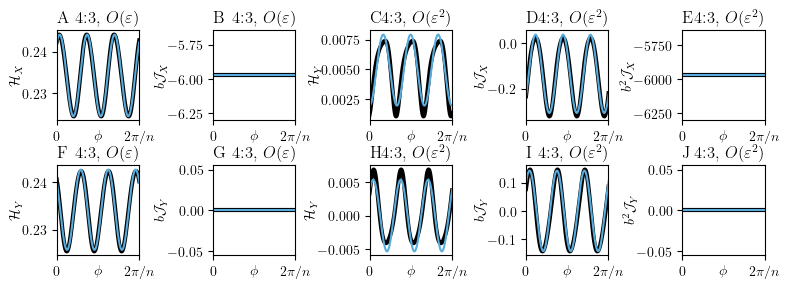

In [65]:
labels = ['A ','B ','C ','D ','E ','F ','G ','H' ,'I ','J ']
titles = [r'$O(\varepsilon)$',r'$O(\varepsilon)$',
          r'$O(\varepsilon^2)$',r'$O(\varepsilon^2)$',r'$O(\varepsilon^2)$',
         r'$O(\varepsilon)$',r'$O(\varepsilon)$',
          r'$O(\varepsilon^2)$',r'$O(\varepsilon^2)$',r'$O(\varepsilon^2)$']

pi_label_short = [r"$0$", r"$2\pi/n$"]
import matplotlib
matplotlib.rcParams['font.family'] = 'serif'
matplotlib.rcParams['text.usetex'] = True
matplotlib.rcParams['pgf.texsystem'] = 'pdflatex'
#matplotlib.rcParams['font.size'] = 12


preamble = (r'\usepackage{amsmath}'
            r'\usepackage{siunitx}'
            r'\usepackage{bm}'
            r'\newcommand{\ve}{\varepsilon}')

matplotlib.rcParams['text.latex.preamble'] = preamble
fontsize = 12

fig,axs = plt.subplots(2,5,figsize=(8,3))

axs[0,0].plot(a.x,a.system1.h['dat_hom'][0],color='k',lw=3)
axs[0,0].plot(a.x,tot1o1,label = 'Approx.',color='#57acdc')


axs[0,1].plot(a.x,a.system1.h['dat_het'][0][0],color='k',lw=3)
axs[0,1].plot(a.x,tot1o1c1+0*a.x,label = 'Approx.',color='#57acdc')

axs[0,2].plot(a.x,a.system1.h['dat_hom'][1],color='k',lw=3)
axs[0,2].plot(a.x,tot1o2,color='#57acdc')


axs[0,3].plot(a.x,a.system1.h['dat_het'][1][0],color='k',lw=3)
axs[0,3].plot(a.x,tot1o2c1+0*a.x,color='#57acdc')

axs[0,4].plot(a.x,a.system1.h['dat_het'][1][1],color='k',lw=3)
axs[0,4].plot(a.x,tot1o2c2+0*a.x,color='#57acdc')

axs[1,0].plot(a.x,a.system2.h['dat_hom'][0],color='k',lw=3)
axs[1,0].plot(a.x,tot2o1,color='#57acdc')

axs[1,1].plot(a.x,a.system2.h['dat_het'][0][0],color='k',lw=3)
axs[1,1].plot(a.x,tot2o1c1+0*a.x,color='#57acdc')

axs[1,2].plot(a.x,a.system2.h['dat_hom'][1],color='k',lw=3)
axs[1,2].plot(a.x,tot2o2,color='#57acdc')

axs[1,3].plot(a.x,a.system2.h['dat_het'][1][0],color='k',lw=3)
axs[1,3].plot(a.x,tot2o2c1+0*a.x,color='#57acdc')

axs[1,4].plot(a.x,a.system2.h['dat_het'][1][1],color='k',lw=3)
axs[1,4].plot(a.x,tot2o2c2+0*a.x,color='#57acdc')


axs = axs.flatten()
for k,label in enumerate(labels):
    axs[k].set_title(label,loc='left')
    axs[k].set_xticks([0,2*np.pi/a._n[1]])
    axs[k].set_xticklabels(pi_label_short)

    axs[k].set_xlabel(r'$\phi$',labelpad=-10);axs[k].set_xlim(0,2*np.pi/a._n[1])

    
    if k in [1,3]:
        axs[k].set_ylabel(r'$b\mathcal{J}_X$',labelpad=0)
    elif k in [6,8]:
        axs[k].set_ylabel(r'$b\mathcal{J}_Y$',labelpad=0)
    elif k in [4]:
        axs[k].set_ylabel(r'$b^2\mathcal{J}_X$',labelpad=0)
    elif k in [9]:
        axs[k].set_ylabel(r'$b^2\mathcal{J}_Y$',labelpad=0)
    elif k in [0,1]:
        axs[k].set_ylabel(r'$\mathcal{H}_X$',labelpad=0)
    else:
        axs[k].set_ylabel(r'$\mathcal{H}_Y$',labelpad=0)

    ti1 = axs[k].get_title()
    ti1 += r'$\quad$'+str(a._n[1])+':'+str(a._m[1])
    ti1 += ', '+titles[k]
    
    axs[k].set_title(ti1,loc='right')

# axs[0].legend()

plt.tight_layout()
plt.subplots_adjust(wspace=.9,hspace=.5)
plt.savefig('fourier{}{}.pdf'.format(a._n[1],a._m[1]))

#axs